In [1]:
import pickle
import numpy as np
import os
import torch
import json
import shlex
import pickle
import time
import subprocess
import numpy as np
import torch.utils.data as data
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import datasets.data_utils as d_utils
import pandas as pd

from sklearn.metrics import roc_auc_score,confusion_matrix
from sklearn.metrics import accuracy_score
from utils.util import AverageMeter, shapenetpart_metrics
from models.backbones import ResNet
from models.heads import ClassifierResNet, MultiPartSegHeadResNet, SceneSegHeadResNet
from models.losses import LabelSmoothingCrossEntropyLoss, MultiShapeCrossEntropy, MaskedCrossEntropy
from utils.config import config, update_config
from utils.lr_scheduler import get_scheduler
from torchvision import transforms
from sklearn.metrics import roc_curve, auc
from IPython.display import clear_output
import pickle

def config_seting(cfg = 'cfgs/brain/brain.yaml'):
    update_config(cfg)
    return config


In [2]:

class BrainDataSeg():
    def __init__(self, data_type = 'train', num_points = 2048, 
                 transforms=None,
                 data_post = '',
                 datafolder = 'BrainData'):
        self.num_points = num_points
        self.transforms = transforms
        if data_type == 'test':
            filename = f'data/{datafolder}/test_data{data_post}.pkl'
        if data_type == 'train':
            filename = f'data/{datafolder}/trainval_data{data_post}.pkl'
        with open(filename, 'rb') as f:
            self.points, self.points_labels, self.labels = pickle.load(f)
        print(f"{filename} loaded successfully")

    def __getitem__(self, idx):
        current_points = self.points[idx]
        current_points_labels = self.points_labels[idx]
        cur_num_points = current_points.shape[0]
        if cur_num_points >= self.num_points:
            choice = np.random.choice(cur_num_points, self.num_points)
            current_points = current_points[choice, :]
            current_points_labels = current_points_labels[choice]
            mask = torch.ones(self.num_points).type(torch.int32)
        else:
            padding_num = self.num_points - cur_num_points
            shuffle_choice = np.random.permutation(np.arange(cur_num_points))
            padding_choice = np.random.choice(cur_num_points, padding_num)
            choice = np.hstack([shuffle_choice, padding_choice])
            current_points = current_points[choice, :]
            current_points_labels = current_points_labels[choice]
            mask = torch.cat([torch.ones(cur_num_points), torch.zeros(padding_num)]).type(torch.int32)
        if self.transforms is not None:
            current_points = self.transforms(current_points)
        label = torch.from_numpy(self.labels[idx]).type(torch.int64)
        current_points_labels = torch.from_numpy(current_points_labels).type(torch.int64)

        return current_points, mask, current_points_labels, label

    def __len__(self):
        return len(self.points)
def get_loader(num_points,batch_size = 16,data_post = '', datafolder = 'BrainData'):
    trans = transforms.Compose([d_utils.PointcloudToTensor()])
    train_dataset = BrainDataSeg(num_points=num_points,
                                 data_type = 'train',
                                 transforms = trans, 
                                 data_post = data_post,
                                 datafolder = datafolder
                                )
    test_dataset = BrainDataSeg(num_points=num_points,
                                data_type = 'test',
                                transforms = trans, 
                                data_post = data_post,
                               datafolder = datafolder)
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               pin_memory=True,
                                               drop_last=True)

    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              pin_memory=True,
                                              drop_last=False)

    return train_loader, test_loader
class MultiPartSegmentationModel(nn.Module):
    def __init__(self, config, backbone, head, num_classes, num_parts,
                 input_features_dim, radius, sampleDl, nsamples, npoints,
                 width=144, depth=2, bottleneck_ratio=2):
        super(MultiPartSegmentationModel, self).__init__()
        if backbone == 'resnet':
            self.backbone = ResNet(config, input_features_dim, radius, sampleDl, nsamples, npoints,
                                   width=width, depth=depth, bottleneck_ratio=bottleneck_ratio)
        else:
            raise NotImplementedError(f"Backbone {backbone} not implemented in Multi-Part Segmentation Model")

        if head == 'resnet_part_seg':
            self.segmentation_head = MultiPartSegHeadResNet(num_classes, width, radius, nsamples, num_parts)
        else:
            raise NotImplementedError(f"Head {backbone} not implemented in Multi-Part Segmentation Model")

    def forward(self, xyz, mask, features):
        end_points = self.backbone(xyz, mask, features)
        return self.segmentation_head(end_points)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
def build_multi_part_segmentation(config, weights = None):
    model = MultiPartSegmentationModel(config, config.backbone, config.head, config.num_classes, config.num_parts,
                                       config.input_features_dim,
                                       config.radius, config.sampleDl, config.nsamples, config.npoints,
                                       config.width, config.depth, config.bottleneck_ratio)
    criterion = MultiShapeCrossEntropy(config.num_classes, weights)
    return model, criterion
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

def train(epoch, train_loader, model, criterion, optimizer, scheduler, config):
    """
    One epoch training
    """
    model.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    loss_meter = AverageMeter()
    end = time.time()
    pred_soft_flats = []
    points_labels_flats = []
    for idx, (points, mask, points_labels, shape_labels) in enumerate(train_loader):
        data_time.update(time.time() - end)
        bsz = points.size(0)
        # forward
        features = points
        features = features.transpose(1, 2).contiguous()

        points = points.cuda(non_blocking=True)
        mask = mask.cuda(non_blocking=True)
        features = features.cuda(non_blocking=True)
        points_labels = points_labels.cuda(non_blocking=True)
        shape_labels = shape_labels.cuda(non_blocking=True)
        pred = model(points, mask, features)
        loss = criterion(pred, points_labels, shape_labels)
        
        m = torch.nn.Softmax(dim=1)
        pred_soft_flats += list(np.array(m(pred[0])[:,1,:].reshape(-1).detach().cpu()))
        points_labels_flats += list(np.array(points_labels.reshape(-1).detach().cpu()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # update meters
        loss_meter.update(loss.item(), bsz)
        batch_time.update(time.time() - end)
        end = time.time()

    print('roc train',roc_auc_score(points_labels_flats,pred_soft_flats))
    opt = Find_Optimal_Cutoff(points_labels_flats, pred_soft_flats)
    print('optimal cut',opt)

    return loss_meter.avg, opt

def validate(epoch, test_loader, model, criterion, config, num_votes=10, is_conf = False):
    """
    One epoch validating
    """
    batch_time = AverageMeter()
    losses = AverageMeter()

    model.eval()
    with torch.no_grad():
        all_logits = []
        all_points_labels = []
        all_shape_labels = []
        all_masks = []
        end = time.time()
        TS = d_utils.BatchPointcloudScaleAndJitter(scale_low=config.scale_low,
                                                   scale_high=config.scale_high,
                                                   std=config.noise_std,
                                                   clip=config.noise_clip)
        pred_soft_flats = []
        points_labels_flats = []
        for idx, (points_orig, mask, points_labels, shape_labels) in enumerate(test_loader):
            vote_logits = None
            vote_points_labels = None
            vote_shape_labels = None
            vote_masks = None
            for v in range(num_votes):
                batch_logits = []
                batch_points_labels = []
                batch_shape_labels = []
                batch_masks = []
                # augment for voting
                if v > 0:
                    points = TS(points_orig)
                else:
                    points = points_orig
                # forward
                features = points
                features = features.transpose(1, 2).contiguous()
                points = points.cuda(non_blocking=True)
                mask = mask.cuda(non_blocking=True)
                features = features.cuda(non_blocking=True)
                points_labels = points_labels.cuda(non_blocking=True)
                shape_labels = shape_labels.cuda(non_blocking=True)

                pred = model(points, mask, features)
                loss = criterion(pred, points_labels, shape_labels)
                losses.update(loss.item(), points.size(0))
                
                m = torch.nn.Softmax(dim=1)
                pred_soft_flats += list(np.array(m(pred[0])[:,1,:].reshape(-1).detach().cpu()))
                points_labels_flats += list(np.array(points_labels.reshape(-1).detach().cpu()))
                

                # collect
                bsz = points.shape[0]
                for ib in range(bsz):
                    sl = shape_labels[ib]
                    logits = pred[sl][ib]
                    pl = points_labels[ib]
                    pmk = mask[ib]
                    batch_logits.append(logits.cpu().numpy())
                    batch_points_labels.append(pl.cpu().numpy())
                    batch_shape_labels.append(sl.cpu().numpy())
                    batch_masks.append(pmk.cpu().numpy().astype(np.bool))

                # measure elapsed time
                batch_time.update(time.time() - end)
                end = time.time()

                if vote_logits is None:
                    vote_logits = batch_logits
                    vote_points_labels = batch_points_labels
                    vote_shape_labels = batch_shape_labels
                    vote_masks = batch_masks
                else:
                    for i in range(len(vote_logits)):
                        vote_logits[i] = vote_logits[i] + (batch_logits[i] - vote_logits[i]) / (v + 1)

            all_logits += vote_logits
            all_points_labels += vote_points_labels
            all_shape_labels += vote_shape_labels
            all_masks += vote_masks
            if idx % config.print_freq == 0:
                print(
                    f'V{num_votes} Test: [{idx}/{len(test_loader)}]\t'
                    f'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    f'Loss {losses.val:.4f} ({losses.avg:.4f})')
                

        print('roc test',roc_auc_score(points_labels_flats,pred_soft_flats))
            
        if is_conf:
            acc, shape_ious, msIoU, mIoU, confs = shapenetpart_metrics(config.num_classes,
                                                            config.num_parts,
                                                            all_shape_labels,
                                                            all_logits,
                                                            all_points_labels,
                                                            all_masks, is_conf = is_conf)
        else:
            acc, shape_ious, msIoU, mIoU = shapenetpart_metrics(config.num_classes,
                                                            config.num_parts,
                                                            all_shape_labels,
                                                            all_logits,
                                                            all_points_labels,
                                                            all_masks, is_conf = is_conf)
            
    if is_conf:
        return losses.avg,acc, msIoU, mIoU, confs
    else:
        return losses.avg,acc, msIoU, mIoU

In [3]:
# Brain Data FCD
WEIGHTS = [1,167]
CFG = 'cfgs/brain/brain3exp.yaml'
IS_CONF = True
DATAFOLDER = 'BrainData'

In [4]:
config = config_seting(CFG)

/home/guest/CloserLook3D/pytorch/utils/config.py:108: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  exp_config = edict(yaml.load(f))


In [5]:
def d(x, thr):
    if x > thr:
        return 1
    return 0

In [68]:
from tqdm import tqdm
model, _ = build_multi_part_segmentation(config, WEIGHTS)

res = []
dice = []
count_good = 0
cms = []
stds = []
ious = []
std_iou = []
for e in range(15):
    cm = np.zeros((2,2))
    dice_ = []
    iou = []
    for k in tqdm(range(20)):
        DATA_POSTFIX = f'_3exp_{e}'
        train_loader, test_loader = get_loader(num_points = config.num_points, 
                                           data_post = DATA_POSTFIX, 
                                           datafolder = DATAFOLDER )
        try:
            model.load_state_dict(torch.load(f'3_exp_{e}_model.pkl'))
        except Exception:
            print('Model was to bad and didn;t converge!')
            pass
        model.cuda()
        model.eval()

        points,mask, true,_ = test_loader.dataset[0]
        features = points.unsqueeze(0).transpose(1, 2).contiguous().cuda()
        points = points.unsqueeze(0).cuda()
        mask = mask.unsqueeze(0).cuda()
        true = true.detach().cpu().numpy()
        opt = 0.5

        pred = [d(x,opt) for x in model(points,mask,features)[0].squeeze(0)[1:].squeeze(0).detach().cpu().numpy()]
        #accuracy_score(true,pred)
        cm = cm + confusion_matrix(true,pred)
        dice_.append(2*np.logical_and(true, pred).sum()/ (true.sum() + sum(pred)))
        iou.append(np.logical_and(true, pred).sum()/ np.logical_or(true, pred).sum())
    print(cm)
    cms.append(cm)
    if (cm[0][1]/cm[0].sum() < 0.1) and (cm[1][0]/cm[1].sum() < 0.2):
        count_good +=1
    dice_ = np.array(dice_)
    dice.append(dice_.mean())
    ious.append(np.array(iou).mean())
    stds.append(dice_.std())
    std_iou.append(np.array(iou).std())
    print('dice: ', dice_.mean())
    print('dice std: ', dice_.std())
    print('iou: ', np.array(iou).mean())
    print('iou std: ', np.array(iou).std())
    res.append([points, true, pred])

  0%|          | 0/20 [00:00<?, ?it/s]

data/BrainData/trainval_data_3exp_0.pkl loaded successfully
data/BrainData/test_data_3exp_0.pkl loaded successfully


  5%|▌         | 1/20 [00:02<00:41,  2.21s/it]

data/BrainData/trainval_data_3exp_0.pkl loaded successfully
data/BrainData/test_data_3exp_0.pkl loaded successfully


 10%|█         | 2/20 [00:03<00:36,  2.05s/it]

data/BrainData/trainval_data_3exp_0.pkl loaded successfully
data/BrainData/test_data_3exp_0.pkl loaded successfully


 15%|█▌        | 3/20 [00:05<00:32,  1.94s/it]

data/BrainData/trainval_data_3exp_0.pkl loaded successfully
data/BrainData/test_data_3exp_0.pkl loaded successfully


 20%|██        | 4/20 [00:07<00:29,  1.86s/it]

data/BrainData/trainval_data_3exp_0.pkl loaded successfully
data/BrainData/test_data_3exp_0.pkl loaded successfully


 25%|██▌       | 5/20 [00:08<00:26,  1.79s/it]

data/BrainData/trainval_data_3exp_0.pkl loaded successfully
data/BrainData/test_data_3exp_0.pkl loaded successfully


 30%|███       | 6/20 [00:10<00:24,  1.74s/it]

data/BrainData/trainval_data_3exp_0.pkl loaded successfully
data/BrainData/test_data_3exp_0.pkl loaded successfully


 35%|███▌      | 7/20 [00:12<00:22,  1.71s/it]

data/BrainData/trainval_data_3exp_0.pkl loaded successfully
data/BrainData/test_data_3exp_0.pkl loaded successfully


 40%|████      | 8/20 [00:13<00:20,  1.69s/it]

data/BrainData/trainval_data_3exp_0.pkl loaded successfully
data/BrainData/test_data_3exp_0.pkl loaded successfully


 45%|████▌     | 9/20 [00:15<00:18,  1.67s/it]

data/BrainData/trainval_data_3exp_0.pkl loaded successfully
data/BrainData/test_data_3exp_0.pkl loaded successfully


 50%|█████     | 10/20 [00:17<00:16,  1.67s/it]

data/BrainData/trainval_data_3exp_0.pkl loaded successfully
data/BrainData/test_data_3exp_0.pkl loaded successfully


 55%|█████▌    | 11/20 [00:18<00:15,  1.67s/it]

data/BrainData/trainval_data_3exp_0.pkl loaded successfully
data/BrainData/test_data_3exp_0.pkl loaded successfully


 60%|██████    | 12/20 [00:20<00:13,  1.69s/it]

data/BrainData/trainval_data_3exp_0.pkl loaded successfully
data/BrainData/test_data_3exp_0.pkl loaded successfully


 65%|██████▌   | 13/20 [00:22<00:11,  1.68s/it]

data/BrainData/trainval_data_3exp_0.pkl loaded successfully
data/BrainData/test_data_3exp_0.pkl loaded successfully


 70%|███████   | 14/20 [00:23<00:09,  1.66s/it]

data/BrainData/trainval_data_3exp_0.pkl loaded successfully
data/BrainData/test_data_3exp_0.pkl loaded successfully


 75%|███████▌  | 15/20 [00:25<00:08,  1.66s/it]

data/BrainData/trainval_data_3exp_0.pkl loaded successfully
data/BrainData/test_data_3exp_0.pkl loaded successfully


 80%|████████  | 16/20 [00:27<00:06,  1.65s/it]

data/BrainData/trainval_data_3exp_0.pkl loaded successfully
data/BrainData/test_data_3exp_0.pkl loaded successfully


 85%|████████▌ | 17/20 [00:28<00:04,  1.65s/it]

data/BrainData/trainval_data_3exp_0.pkl loaded successfully
data/BrainData/test_data_3exp_0.pkl loaded successfully


 90%|█████████ | 18/20 [00:30<00:03,  1.64s/it]

data/BrainData/trainval_data_3exp_0.pkl loaded successfully
data/BrainData/test_data_3exp_0.pkl loaded successfully


 95%|█████████▌| 19/20 [00:31<00:01,  1.63s/it]

data/BrainData/trainval_data_3exp_0.pkl loaded successfully
data/BrainData/test_data_3exp_0.pkl loaded successfully


  0%|          | 0/20 [00:00<?, ?it/s]

[[373064.  33934.]
 [   757.   1845.]]
dice:  0.0958762929575304
dice std:  0.03159664264720952
iou:  0.050636960306960764
iou std:  0.01717942120656254
data/BrainData/trainval_data_3exp_1.pkl loaded successfully
data/BrainData/test_data_3exp_1.pkl loaded successfully


  5%|▌         | 1/20 [00:01<00:34,  1.81s/it]

data/BrainData/trainval_data_3exp_1.pkl loaded successfully
data/BrainData/test_data_3exp_1.pkl loaded successfully


 10%|█         | 2/20 [00:03<00:31,  1.74s/it]

data/BrainData/trainval_data_3exp_1.pkl loaded successfully
data/BrainData/test_data_3exp_1.pkl loaded successfully


 15%|█▌        | 3/20 [00:04<00:28,  1.70s/it]

data/BrainData/trainval_data_3exp_1.pkl loaded successfully
data/BrainData/test_data_3exp_1.pkl loaded successfully


 20%|██        | 4/20 [00:06<00:26,  1.67s/it]

data/BrainData/trainval_data_3exp_1.pkl loaded successfully
data/BrainData/test_data_3exp_1.pkl loaded successfully


 25%|██▌       | 5/20 [00:08<00:24,  1.66s/it]

data/BrainData/trainval_data_3exp_1.pkl loaded successfully
data/BrainData/test_data_3exp_1.pkl loaded successfully


 30%|███       | 6/20 [00:09<00:23,  1.64s/it]

data/BrainData/trainval_data_3exp_1.pkl loaded successfully
data/BrainData/test_data_3exp_1.pkl loaded successfully


 35%|███▌      | 7/20 [00:11<00:21,  1.64s/it]

data/BrainData/trainval_data_3exp_1.pkl loaded successfully
data/BrainData/test_data_3exp_1.pkl loaded successfully


 40%|████      | 8/20 [00:13<00:19,  1.65s/it]

data/BrainData/trainval_data_3exp_1.pkl loaded successfully
data/BrainData/test_data_3exp_1.pkl loaded successfully


 45%|████▌     | 9/20 [00:14<00:17,  1.63s/it]

data/BrainData/trainval_data_3exp_1.pkl loaded successfully
data/BrainData/test_data_3exp_1.pkl loaded successfully


 50%|█████     | 10/20 [00:16<00:16,  1.64s/it]

data/BrainData/trainval_data_3exp_1.pkl loaded successfully
data/BrainData/test_data_3exp_1.pkl loaded successfully


 55%|█████▌    | 11/20 [00:18<00:14,  1.65s/it]

data/BrainData/trainval_data_3exp_1.pkl loaded successfully
data/BrainData/test_data_3exp_1.pkl loaded successfully


 60%|██████    | 12/20 [00:19<00:13,  1.64s/it]

data/BrainData/trainval_data_3exp_1.pkl loaded successfully
data/BrainData/test_data_3exp_1.pkl loaded successfully


 65%|██████▌   | 13/20 [00:21<00:11,  1.62s/it]

data/BrainData/trainval_data_3exp_1.pkl loaded successfully
data/BrainData/test_data_3exp_1.pkl loaded successfully


 70%|███████   | 14/20 [00:22<00:09,  1.62s/it]

data/BrainData/trainval_data_3exp_1.pkl loaded successfully
data/BrainData/test_data_3exp_1.pkl loaded successfully


 75%|███████▌  | 15/20 [00:24<00:08,  1.61s/it]

data/BrainData/trainval_data_3exp_1.pkl loaded successfully
data/BrainData/test_data_3exp_1.pkl loaded successfully


 80%|████████  | 16/20 [00:26<00:06,  1.63s/it]

data/BrainData/trainval_data_3exp_1.pkl loaded successfully
data/BrainData/test_data_3exp_1.pkl loaded successfully


 85%|████████▌ | 17/20 [00:27<00:04,  1.62s/it]

data/BrainData/trainval_data_3exp_1.pkl loaded successfully
data/BrainData/test_data_3exp_1.pkl loaded successfully


 90%|█████████ | 18/20 [00:29<00:03,  1.62s/it]

data/BrainData/trainval_data_3exp_1.pkl loaded successfully
data/BrainData/test_data_3exp_1.pkl loaded successfully


 95%|█████████▌| 19/20 [00:30<00:01,  1.61s/it]

data/BrainData/trainval_data_3exp_1.pkl loaded successfully
data/BrainData/test_data_3exp_1.pkl loaded successfully


  0%|          | 0/20 [00:00<?, ?it/s]

[[392265.  15030.]
 [  1409.    896.]]
dice:  0.07541341353665973
dice std:  0.09013841449576207
iou:  0.04161931567421569
iou std:  0.05207479860550267
data/BrainData/trainval_data_3exp_2.pkl loaded successfully
data/BrainData/test_data_3exp_2.pkl loaded successfully


  5%|▌         | 1/20 [00:01<00:31,  1.65s/it]

data/BrainData/trainval_data_3exp_2.pkl loaded successfully
data/BrainData/test_data_3exp_2.pkl loaded successfully


 10%|█         | 2/20 [00:03<00:29,  1.65s/it]

data/BrainData/trainval_data_3exp_2.pkl loaded successfully
data/BrainData/test_data_3exp_2.pkl loaded successfully


 15%|█▌        | 3/20 [00:04<00:27,  1.64s/it]

data/BrainData/trainval_data_3exp_2.pkl loaded successfully
data/BrainData/test_data_3exp_2.pkl loaded successfully


 20%|██        | 4/20 [00:06<00:26,  1.63s/it]

data/BrainData/trainval_data_3exp_2.pkl loaded successfully
data/BrainData/test_data_3exp_2.pkl loaded successfully


 25%|██▌       | 5/20 [00:08<00:24,  1.63s/it]

data/BrainData/trainval_data_3exp_2.pkl loaded successfully
data/BrainData/test_data_3exp_2.pkl loaded successfully


 30%|███       | 6/20 [00:09<00:22,  1.64s/it]

data/BrainData/trainval_data_3exp_2.pkl loaded successfully
data/BrainData/test_data_3exp_2.pkl loaded successfully


 35%|███▌      | 7/20 [00:11<00:21,  1.64s/it]

data/BrainData/trainval_data_3exp_2.pkl loaded successfully
data/BrainData/test_data_3exp_2.pkl loaded successfully


 40%|████      | 8/20 [00:13<00:19,  1.62s/it]

data/BrainData/trainval_data_3exp_2.pkl loaded successfully
data/BrainData/test_data_3exp_2.pkl loaded successfully


 45%|████▌     | 9/20 [00:14<00:17,  1.62s/it]

data/BrainData/trainval_data_3exp_2.pkl loaded successfully
data/BrainData/test_data_3exp_2.pkl loaded successfully


 50%|█████     | 10/20 [00:16<00:16,  1.63s/it]

data/BrainData/trainval_data_3exp_2.pkl loaded successfully
data/BrainData/test_data_3exp_2.pkl loaded successfully


 55%|█████▌    | 11/20 [00:17<00:14,  1.63s/it]

data/BrainData/trainval_data_3exp_2.pkl loaded successfully
data/BrainData/test_data_3exp_2.pkl loaded successfully


 60%|██████    | 12/20 [00:19<00:13,  1.64s/it]

data/BrainData/trainval_data_3exp_2.pkl loaded successfully
data/BrainData/test_data_3exp_2.pkl loaded successfully


 65%|██████▌   | 13/20 [00:21<00:11,  1.63s/it]

data/BrainData/trainval_data_3exp_2.pkl loaded successfully
data/BrainData/test_data_3exp_2.pkl loaded successfully


 70%|███████   | 14/20 [00:22<00:09,  1.62s/it]

data/BrainData/trainval_data_3exp_2.pkl loaded successfully
data/BrainData/test_data_3exp_2.pkl loaded successfully


 75%|███████▌  | 15/20 [00:24<00:08,  1.62s/it]

data/BrainData/trainval_data_3exp_2.pkl loaded successfully
data/BrainData/test_data_3exp_2.pkl loaded successfully


 80%|████████  | 16/20 [00:26<00:06,  1.61s/it]

data/BrainData/trainval_data_3exp_2.pkl loaded successfully
data/BrainData/test_data_3exp_2.pkl loaded successfully


 85%|████████▌ | 17/20 [00:27<00:04,  1.61s/it]

data/BrainData/trainval_data_3exp_2.pkl loaded successfully
data/BrainData/test_data_3exp_2.pkl loaded successfully


 90%|█████████ | 18/20 [00:29<00:03,  1.62s/it]

data/BrainData/trainval_data_3exp_2.pkl loaded successfully
data/BrainData/test_data_3exp_2.pkl loaded successfully


 95%|█████████▌| 19/20 [00:30<00:01,  1.61s/it]

data/BrainData/trainval_data_3exp_2.pkl loaded successfully
data/BrainData/test_data_3exp_2.pkl loaded successfully


  0%|          | 0/20 [00:00<?, ?it/s]

[[391456.  15223.]
 [  1441.   1480.]]
dice:  0.12278354766618757
dice std:  0.08506124491309798
iou:  0.06757368434443746
iou std:  0.047837613178421265
data/BrainData/trainval_data_3exp_3.pkl loaded successfully
data/BrainData/test_data_3exp_3.pkl loaded successfully


  5%|▌         | 1/20 [00:01<00:30,  1.60s/it]

data/BrainData/trainval_data_3exp_3.pkl loaded successfully
data/BrainData/test_data_3exp_3.pkl loaded successfully


 10%|█         | 2/20 [00:03<00:29,  1.62s/it]

data/BrainData/trainval_data_3exp_3.pkl loaded successfully
data/BrainData/test_data_3exp_3.pkl loaded successfully


 15%|█▌        | 3/20 [00:04<00:27,  1.60s/it]

data/BrainData/trainval_data_3exp_3.pkl loaded successfully
data/BrainData/test_data_3exp_3.pkl loaded successfully


 20%|██        | 4/20 [00:06<00:25,  1.61s/it]

data/BrainData/trainval_data_3exp_3.pkl loaded successfully
data/BrainData/test_data_3exp_3.pkl loaded successfully


 25%|██▌       | 5/20 [00:08<00:24,  1.61s/it]

data/BrainData/trainval_data_3exp_3.pkl loaded successfully
data/BrainData/test_data_3exp_3.pkl loaded successfully


 30%|███       | 6/20 [00:09<00:22,  1.63s/it]

data/BrainData/trainval_data_3exp_3.pkl loaded successfully
data/BrainData/test_data_3exp_3.pkl loaded successfully


 35%|███▌      | 7/20 [00:11<00:21,  1.63s/it]

data/BrainData/trainval_data_3exp_3.pkl loaded successfully
data/BrainData/test_data_3exp_3.pkl loaded successfully


 40%|████      | 8/20 [00:13<00:19,  1.63s/it]

data/BrainData/trainval_data_3exp_3.pkl loaded successfully
data/BrainData/test_data_3exp_3.pkl loaded successfully


 45%|████▌     | 9/20 [00:14<00:17,  1.63s/it]

data/BrainData/trainval_data_3exp_3.pkl loaded successfully
data/BrainData/test_data_3exp_3.pkl loaded successfully


 50%|█████     | 10/20 [00:16<00:16,  1.64s/it]

data/BrainData/trainval_data_3exp_3.pkl loaded successfully
data/BrainData/test_data_3exp_3.pkl loaded successfully


 55%|█████▌    | 11/20 [00:17<00:14,  1.65s/it]

data/BrainData/trainval_data_3exp_3.pkl loaded successfully
data/BrainData/test_data_3exp_3.pkl loaded successfully


 60%|██████    | 12/20 [00:19<00:13,  1.63s/it]

data/BrainData/trainval_data_3exp_3.pkl loaded successfully
data/BrainData/test_data_3exp_3.pkl loaded successfully


 65%|██████▌   | 13/20 [00:21<00:11,  1.62s/it]

data/BrainData/trainval_data_3exp_3.pkl loaded successfully
data/BrainData/test_data_3exp_3.pkl loaded successfully


 70%|███████   | 14/20 [00:22<00:09,  1.63s/it]

data/BrainData/trainval_data_3exp_3.pkl loaded successfully
data/BrainData/test_data_3exp_3.pkl loaded successfully


 75%|███████▌  | 15/20 [00:24<00:08,  1.64s/it]

data/BrainData/trainval_data_3exp_3.pkl loaded successfully
data/BrainData/test_data_3exp_3.pkl loaded successfully


 80%|████████  | 16/20 [00:26<00:06,  1.63s/it]

data/BrainData/trainval_data_3exp_3.pkl loaded successfully
data/BrainData/test_data_3exp_3.pkl loaded successfully


 85%|████████▌ | 17/20 [00:27<00:04,  1.63s/it]

data/BrainData/trainval_data_3exp_3.pkl loaded successfully
data/BrainData/test_data_3exp_3.pkl loaded successfully


 90%|█████████ | 18/20 [00:29<00:03,  1.63s/it]

data/BrainData/trainval_data_3exp_3.pkl loaded successfully
data/BrainData/test_data_3exp_3.pkl loaded successfully


 95%|█████████▌| 19/20 [00:30<00:01,  1.63s/it]

data/BrainData/trainval_data_3exp_3.pkl loaded successfully
data/BrainData/test_data_3exp_3.pkl loaded successfully


  0%|          | 0/20 [00:00<?, ?it/s]

[[4.00256e+05 9.20000e+03]
 [1.19000e+02 2.50000e+01]]
dice:  0.003996498357335608
dice std:  0.006763495112148448
iou:  0.002013815341168187
iou std:  0.0034130628700786863
data/BrainData/trainval_data_3exp_4.pkl loaded successfully
data/BrainData/test_data_3exp_4.pkl loaded successfully


  5%|▌         | 1/20 [00:01<00:30,  1.62s/it]

data/BrainData/trainval_data_3exp_4.pkl loaded successfully
data/BrainData/test_data_3exp_4.pkl loaded successfully


 10%|█         | 2/20 [00:03<00:29,  1.62s/it]

data/BrainData/trainval_data_3exp_4.pkl loaded successfully
data/BrainData/test_data_3exp_4.pkl loaded successfully


 15%|█▌        | 3/20 [00:04<00:27,  1.62s/it]

data/BrainData/trainval_data_3exp_4.pkl loaded successfully
data/BrainData/test_data_3exp_4.pkl loaded successfully


 20%|██        | 4/20 [00:06<00:26,  1.64s/it]

data/BrainData/trainval_data_3exp_4.pkl loaded successfully
data/BrainData/test_data_3exp_4.pkl loaded successfully


 25%|██▌       | 5/20 [00:08<00:24,  1.63s/it]

data/BrainData/trainval_data_3exp_4.pkl loaded successfully
data/BrainData/test_data_3exp_4.pkl loaded successfully


 30%|███       | 6/20 [00:09<00:22,  1.63s/it]

data/BrainData/trainval_data_3exp_4.pkl loaded successfully
data/BrainData/test_data_3exp_4.pkl loaded successfully


 35%|███▌      | 7/20 [00:11<00:21,  1.62s/it]

data/BrainData/trainval_data_3exp_4.pkl loaded successfully
data/BrainData/test_data_3exp_4.pkl loaded successfully


 40%|████      | 8/20 [00:13<00:19,  1.63s/it]

data/BrainData/trainval_data_3exp_4.pkl loaded successfully
data/BrainData/test_data_3exp_4.pkl loaded successfully


 45%|████▌     | 9/20 [00:14<00:17,  1.63s/it]

data/BrainData/trainval_data_3exp_4.pkl loaded successfully
data/BrainData/test_data_3exp_4.pkl loaded successfully


 50%|█████     | 10/20 [00:16<00:16,  1.64s/it]

data/BrainData/trainval_data_3exp_4.pkl loaded successfully
data/BrainData/test_data_3exp_4.pkl loaded successfully


 55%|█████▌    | 11/20 [00:17<00:14,  1.62s/it]

data/BrainData/trainval_data_3exp_4.pkl loaded successfully
data/BrainData/test_data_3exp_4.pkl loaded successfully


 60%|██████    | 12/20 [00:19<00:12,  1.62s/it]

data/BrainData/trainval_data_3exp_4.pkl loaded successfully
data/BrainData/test_data_3exp_4.pkl loaded successfully


 65%|██████▌   | 13/20 [00:21<00:11,  1.63s/it]

data/BrainData/trainval_data_3exp_4.pkl loaded successfully
data/BrainData/test_data_3exp_4.pkl loaded successfully


 70%|███████   | 14/20 [00:22<00:09,  1.62s/it]

data/BrainData/trainval_data_3exp_4.pkl loaded successfully
data/BrainData/test_data_3exp_4.pkl loaded successfully


 75%|███████▌  | 15/20 [00:24<00:08,  1.64s/it]

data/BrainData/trainval_data_3exp_4.pkl loaded successfully
data/BrainData/test_data_3exp_4.pkl loaded successfully


 80%|████████  | 16/20 [00:26<00:06,  1.64s/it]

data/BrainData/trainval_data_3exp_4.pkl loaded successfully
data/BrainData/test_data_3exp_4.pkl loaded successfully


 85%|████████▌ | 17/20 [00:27<00:04,  1.65s/it]

data/BrainData/trainval_data_3exp_4.pkl loaded successfully
data/BrainData/test_data_3exp_4.pkl loaded successfully


 90%|█████████ | 18/20 [00:29<00:03,  1.65s/it]

data/BrainData/trainval_data_3exp_4.pkl loaded successfully
data/BrainData/test_data_3exp_4.pkl loaded successfully


 95%|█████████▌| 19/20 [00:31<00:01,  1.64s/it]

data/BrainData/trainval_data_3exp_4.pkl loaded successfully
data/BrainData/test_data_3exp_4.pkl loaded successfully


  0%|          | 0/20 [00:00<?, ?it/s]

[[3.95481e+05 1.40230e+04]
 [9.60000e+01 0.00000e+00]]
dice:  0.0
dice std:  0.0
iou:  0.0
iou std:  0.0
data/BrainData/trainval_data_3exp_5.pkl loaded successfully
data/BrainData/test_data_3exp_5.pkl loaded successfully


  5%|▌         | 1/20 [00:01<00:31,  1.64s/it]

data/BrainData/trainval_data_3exp_5.pkl loaded successfully
data/BrainData/test_data_3exp_5.pkl loaded successfully


 10%|█         | 2/20 [00:03<00:29,  1.63s/it]

data/BrainData/trainval_data_3exp_5.pkl loaded successfully
data/BrainData/test_data_3exp_5.pkl loaded successfully


 15%|█▌        | 3/20 [00:04<00:27,  1.65s/it]

data/BrainData/trainval_data_3exp_5.pkl loaded successfully
data/BrainData/test_data_3exp_5.pkl loaded successfully


 20%|██        | 4/20 [00:06<00:26,  1.65s/it]

data/BrainData/trainval_data_3exp_5.pkl loaded successfully
data/BrainData/test_data_3exp_5.pkl loaded successfully


 25%|██▌       | 5/20 [00:08<00:24,  1.65s/it]

data/BrainData/trainval_data_3exp_5.pkl loaded successfully
data/BrainData/test_data_3exp_5.pkl loaded successfully


 30%|███       | 6/20 [00:09<00:22,  1.64s/it]

data/BrainData/trainval_data_3exp_5.pkl loaded successfully
data/BrainData/test_data_3exp_5.pkl loaded successfully


 35%|███▌      | 7/20 [00:11<00:21,  1.66s/it]

data/BrainData/trainval_data_3exp_5.pkl loaded successfully
data/BrainData/test_data_3exp_5.pkl loaded successfully


 40%|████      | 8/20 [00:13<00:19,  1.66s/it]

data/BrainData/trainval_data_3exp_5.pkl loaded successfully
data/BrainData/test_data_3exp_5.pkl loaded successfully


 45%|████▌     | 9/20 [00:14<00:18,  1.66s/it]

data/BrainData/trainval_data_3exp_5.pkl loaded successfully
data/BrainData/test_data_3exp_5.pkl loaded successfully


 50%|█████     | 10/20 [00:16<00:16,  1.67s/it]

data/BrainData/trainval_data_3exp_5.pkl loaded successfully
data/BrainData/test_data_3exp_5.pkl loaded successfully


 55%|█████▌    | 11/20 [00:18<00:14,  1.66s/it]

data/BrainData/trainval_data_3exp_5.pkl loaded successfully
data/BrainData/test_data_3exp_5.pkl loaded successfully


 60%|██████    | 12/20 [00:19<00:13,  1.68s/it]

data/BrainData/trainval_data_3exp_5.pkl loaded successfully
data/BrainData/test_data_3exp_5.pkl loaded successfully


 65%|██████▌   | 13/20 [00:21<00:11,  1.67s/it]

data/BrainData/trainval_data_3exp_5.pkl loaded successfully
data/BrainData/test_data_3exp_5.pkl loaded successfully


 70%|███████   | 14/20 [00:23<00:10,  1.67s/it]

data/BrainData/trainval_data_3exp_5.pkl loaded successfully
data/BrainData/test_data_3exp_5.pkl loaded successfully


 75%|███████▌  | 15/20 [00:24<00:08,  1.66s/it]

data/BrainData/trainval_data_3exp_5.pkl loaded successfully
data/BrainData/test_data_3exp_5.pkl loaded successfully


 80%|████████  | 16/20 [00:26<00:06,  1.65s/it]

data/BrainData/trainval_data_3exp_5.pkl loaded successfully
data/BrainData/test_data_3exp_5.pkl loaded successfully


 85%|████████▌ | 17/20 [00:28<00:04,  1.63s/it]

data/BrainData/trainval_data_3exp_5.pkl loaded successfully
data/BrainData/test_data_3exp_5.pkl loaded successfully


 90%|█████████ | 18/20 [00:29<00:03,  1.62s/it]

data/BrainData/trainval_data_3exp_5.pkl loaded successfully
data/BrainData/test_data_3exp_5.pkl loaded successfully


 95%|█████████▌| 19/20 [00:31<00:01,  1.62s/it]

data/BrainData/trainval_data_3exp_5.pkl loaded successfully
data/BrainData/test_data_3exp_5.pkl loaded successfully


  0%|          | 0/20 [00:00<?, ?it/s]

[[3.8906e+05 1.8440e+04]
 [2.0700e+02 1.8930e+03]]
dice:  0.17149891409835816
dice std:  0.03284515071779783
iou:  0.09414680966560034
iou std:  0.0197516110958357
data/BrainData/trainval_data_3exp_6.pkl loaded successfully
data/BrainData/test_data_3exp_6.pkl loaded successfully


  5%|▌         | 1/20 [00:01<00:30,  1.59s/it]

data/BrainData/trainval_data_3exp_6.pkl loaded successfully
data/BrainData/test_data_3exp_6.pkl loaded successfully


 10%|█         | 2/20 [00:03<00:29,  1.61s/it]

data/BrainData/trainval_data_3exp_6.pkl loaded successfully
data/BrainData/test_data_3exp_6.pkl loaded successfully


 15%|█▌        | 3/20 [00:04<00:27,  1.62s/it]

data/BrainData/trainval_data_3exp_6.pkl loaded successfully
data/BrainData/test_data_3exp_6.pkl loaded successfully


 20%|██        | 4/20 [00:06<00:25,  1.61s/it]

data/BrainData/trainval_data_3exp_6.pkl loaded successfully
data/BrainData/test_data_3exp_6.pkl loaded successfully


 25%|██▌       | 5/20 [00:08<00:24,  1.62s/it]

data/BrainData/trainval_data_3exp_6.pkl loaded successfully
data/BrainData/test_data_3exp_6.pkl loaded successfully


 30%|███       | 6/20 [00:09<00:22,  1.62s/it]

data/BrainData/trainval_data_3exp_6.pkl loaded successfully
data/BrainData/test_data_3exp_6.pkl loaded successfully


 35%|███▌      | 7/20 [00:11<00:21,  1.64s/it]

data/BrainData/trainval_data_3exp_6.pkl loaded successfully
data/BrainData/test_data_3exp_6.pkl loaded successfully


 40%|████      | 8/20 [00:13<00:19,  1.63s/it]

data/BrainData/trainval_data_3exp_6.pkl loaded successfully
data/BrainData/test_data_3exp_6.pkl loaded successfully


 45%|████▌     | 9/20 [00:14<00:18,  1.64s/it]

data/BrainData/trainval_data_3exp_6.pkl loaded successfully
data/BrainData/test_data_3exp_6.pkl loaded successfully


 50%|█████     | 10/20 [00:16<00:16,  1.64s/it]

data/BrainData/trainval_data_3exp_6.pkl loaded successfully
data/BrainData/test_data_3exp_6.pkl loaded successfully


 55%|█████▌    | 11/20 [00:18<00:14,  1.65s/it]

data/BrainData/trainval_data_3exp_6.pkl loaded successfully
data/BrainData/test_data_3exp_6.pkl loaded successfully


 60%|██████    | 12/20 [00:19<00:13,  1.64s/it]

data/BrainData/trainval_data_3exp_6.pkl loaded successfully
data/BrainData/test_data_3exp_6.pkl loaded successfully


 65%|██████▌   | 13/20 [00:21<00:11,  1.64s/it]

data/BrainData/trainval_data_3exp_6.pkl loaded successfully
data/BrainData/test_data_3exp_6.pkl loaded successfully


 70%|███████   | 14/20 [00:22<00:09,  1.63s/it]

data/BrainData/trainval_data_3exp_6.pkl loaded successfully
data/BrainData/test_data_3exp_6.pkl loaded successfully


 75%|███████▌  | 15/20 [00:24<00:08,  1.62s/it]

data/BrainData/trainval_data_3exp_6.pkl loaded successfully
data/BrainData/test_data_3exp_6.pkl loaded successfully


 80%|████████  | 16/20 [00:26<00:06,  1.62s/it]

data/BrainData/trainval_data_3exp_6.pkl loaded successfully
data/BrainData/test_data_3exp_6.pkl loaded successfully


 85%|████████▌ | 17/20 [00:27<00:04,  1.63s/it]

data/BrainData/trainval_data_3exp_6.pkl loaded successfully
data/BrainData/test_data_3exp_6.pkl loaded successfully


 90%|█████████ | 18/20 [00:29<00:03,  1.64s/it]

data/BrainData/trainval_data_3exp_6.pkl loaded successfully
data/BrainData/test_data_3exp_6.pkl loaded successfully


 95%|█████████▌| 19/20 [00:31<00:01,  1.63s/it]

data/BrainData/trainval_data_3exp_6.pkl loaded successfully
data/BrainData/test_data_3exp_6.pkl loaded successfully


  0%|          | 0/20 [00:00<?, ?it/s]

[[4.07757e+05 6.88000e+02]
 [1.90000e+01 1.13600e+03]]
dice:  0.8289224235055818
dice std:  0.2050796526372947
iou:  0.7536977489143438
iou std:  0.26407165205539934
data/BrainData/trainval_data_3exp_7.pkl loaded successfully
data/BrainData/test_data_3exp_7.pkl loaded successfully


  5%|▌         | 1/20 [00:01<00:31,  1.67s/it]

data/BrainData/trainval_data_3exp_7.pkl loaded successfully
data/BrainData/test_data_3exp_7.pkl loaded successfully


 10%|█         | 2/20 [00:03<00:29,  1.66s/it]

data/BrainData/trainval_data_3exp_7.pkl loaded successfully
data/BrainData/test_data_3exp_7.pkl loaded successfully


 15%|█▌        | 3/20 [00:04<00:28,  1.66s/it]

data/BrainData/trainval_data_3exp_7.pkl loaded successfully
data/BrainData/test_data_3exp_7.pkl loaded successfully


 20%|██        | 4/20 [00:06<00:26,  1.66s/it]

data/BrainData/trainval_data_3exp_7.pkl loaded successfully
data/BrainData/test_data_3exp_7.pkl loaded successfully


 25%|██▌       | 5/20 [00:08<00:24,  1.65s/it]

data/BrainData/trainval_data_3exp_7.pkl loaded successfully
data/BrainData/test_data_3exp_7.pkl loaded successfully


 30%|███       | 6/20 [00:09<00:22,  1.64s/it]

data/BrainData/trainval_data_3exp_7.pkl loaded successfully
data/BrainData/test_data_3exp_7.pkl loaded successfully


 35%|███▌      | 7/20 [00:11<00:21,  1.62s/it]

data/BrainData/trainval_data_3exp_7.pkl loaded successfully
data/BrainData/test_data_3exp_7.pkl loaded successfully


 40%|████      | 8/20 [00:13<00:19,  1.61s/it]

data/BrainData/trainval_data_3exp_7.pkl loaded successfully
data/BrainData/test_data_3exp_7.pkl loaded successfully


 45%|████▌     | 9/20 [00:14<00:17,  1.62s/it]

data/BrainData/trainval_data_3exp_7.pkl loaded successfully
data/BrainData/test_data_3exp_7.pkl loaded successfully


 50%|█████     | 10/20 [00:16<00:16,  1.62s/it]

data/BrainData/trainval_data_3exp_7.pkl loaded successfully
data/BrainData/test_data_3exp_7.pkl loaded successfully


 55%|█████▌    | 11/20 [00:17<00:14,  1.63s/it]

data/BrainData/trainval_data_3exp_7.pkl loaded successfully
data/BrainData/test_data_3exp_7.pkl loaded successfully


 60%|██████    | 12/20 [00:19<00:12,  1.62s/it]

data/BrainData/trainval_data_3exp_7.pkl loaded successfully
data/BrainData/test_data_3exp_7.pkl loaded successfully


 65%|██████▌   | 13/20 [00:21<00:11,  1.62s/it]

data/BrainData/trainval_data_3exp_7.pkl loaded successfully
data/BrainData/test_data_3exp_7.pkl loaded successfully


 70%|███████   | 14/20 [00:22<00:09,  1.63s/it]

data/BrainData/trainval_data_3exp_7.pkl loaded successfully
data/BrainData/test_data_3exp_7.pkl loaded successfully


 75%|███████▌  | 15/20 [00:24<00:08,  1.65s/it]

data/BrainData/trainval_data_3exp_7.pkl loaded successfully
data/BrainData/test_data_3exp_7.pkl loaded successfully


 80%|████████  | 16/20 [00:26<00:06,  1.64s/it]

data/BrainData/trainval_data_3exp_7.pkl loaded successfully
data/BrainData/test_data_3exp_7.pkl loaded successfully


 85%|████████▌ | 17/20 [00:27<00:04,  1.64s/it]

data/BrainData/trainval_data_3exp_7.pkl loaded successfully
data/BrainData/test_data_3exp_7.pkl loaded successfully


 90%|█████████ | 18/20 [00:29<00:03,  1.63s/it]

data/BrainData/trainval_data_3exp_7.pkl loaded successfully
data/BrainData/test_data_3exp_7.pkl loaded successfully


 95%|█████████▌| 19/20 [00:31<00:01,  1.63s/it]

data/BrainData/trainval_data_3exp_7.pkl loaded successfully
data/BrainData/test_data_3exp_7.pkl loaded successfully


  0%|          | 0/20 [00:00<?, ?it/s]

[[4.07194e+05 1.38400e+03]
 [8.60000e+01 9.36000e+02]]
dice:  0.6616274258196005
dice std:  0.24068192428125948
iou:  0.5423863781132541
iou std:  0.26980291466821504
data/BrainData/trainval_data_3exp_8.pkl loaded successfully
data/BrainData/test_data_3exp_8.pkl loaded successfully
Model was to bad and didn;t converge!


  5%|▌         | 1/20 [00:01<00:29,  1.57s/it]

data/BrainData/trainval_data_3exp_8.pkl loaded successfully
data/BrainData/test_data_3exp_8.pkl loaded successfully
Model was to bad and didn;t converge!


 10%|█         | 2/20 [00:03<00:28,  1.57s/it]

data/BrainData/trainval_data_3exp_8.pkl loaded successfully
data/BrainData/test_data_3exp_8.pkl loaded successfully
Model was to bad and didn;t converge!


 15%|█▌        | 3/20 [00:04<00:26,  1.57s/it]

data/BrainData/trainval_data_3exp_8.pkl loaded successfully
data/BrainData/test_data_3exp_8.pkl loaded successfully
Model was to bad and didn;t converge!


 20%|██        | 4/20 [00:06<00:25,  1.57s/it]

data/BrainData/trainval_data_3exp_8.pkl loaded successfully
data/BrainData/test_data_3exp_8.pkl loaded successfully
Model was to bad and didn;t converge!


 25%|██▌       | 5/20 [00:07<00:23,  1.56s/it]

data/BrainData/trainval_data_3exp_8.pkl loaded successfully
data/BrainData/test_data_3exp_8.pkl loaded successfully
Model was to bad and didn;t converge!


 30%|███       | 6/20 [00:09<00:21,  1.54s/it]

data/BrainData/trainval_data_3exp_8.pkl loaded successfully
data/BrainData/test_data_3exp_8.pkl loaded successfully
Model was to bad and didn;t converge!


 35%|███▌      | 7/20 [00:10<00:19,  1.53s/it]

data/BrainData/trainval_data_3exp_8.pkl loaded successfully
data/BrainData/test_data_3exp_8.pkl loaded successfully
Model was to bad and didn;t converge!


 40%|████      | 8/20 [00:12<00:18,  1.53s/it]

data/BrainData/trainval_data_3exp_8.pkl loaded successfully
data/BrainData/test_data_3exp_8.pkl loaded successfully
Model was to bad and didn;t converge!


 45%|████▌     | 9/20 [00:13<00:16,  1.53s/it]

data/BrainData/trainval_data_3exp_8.pkl loaded successfully
data/BrainData/test_data_3exp_8.pkl loaded successfully
Model was to bad and didn;t converge!


 50%|█████     | 10/20 [00:15<00:15,  1.53s/it]

data/BrainData/trainval_data_3exp_8.pkl loaded successfully
data/BrainData/test_data_3exp_8.pkl loaded successfully
Model was to bad and didn;t converge!


 55%|█████▌    | 11/20 [00:16<00:13,  1.52s/it]

data/BrainData/trainval_data_3exp_8.pkl loaded successfully
data/BrainData/test_data_3exp_8.pkl loaded successfully
Model was to bad and didn;t converge!


 60%|██████    | 12/20 [00:18<00:12,  1.52s/it]

data/BrainData/trainval_data_3exp_8.pkl loaded successfully
data/BrainData/test_data_3exp_8.pkl loaded successfully
Model was to bad and didn;t converge!


 65%|██████▌   | 13/20 [00:19<00:10,  1.52s/it]

data/BrainData/trainval_data_3exp_8.pkl loaded successfully
data/BrainData/test_data_3exp_8.pkl loaded successfully
Model was to bad and didn;t converge!


 70%|███████   | 14/20 [00:21<00:09,  1.53s/it]

data/BrainData/trainval_data_3exp_8.pkl loaded successfully
data/BrainData/test_data_3exp_8.pkl loaded successfully
Model was to bad and didn;t converge!


 75%|███████▌  | 15/20 [00:23<00:07,  1.53s/it]

data/BrainData/trainval_data_3exp_8.pkl loaded successfully
data/BrainData/test_data_3exp_8.pkl loaded successfully
Model was to bad and didn;t converge!


 80%|████████  | 16/20 [00:24<00:06,  1.54s/it]

data/BrainData/trainval_data_3exp_8.pkl loaded successfully
data/BrainData/test_data_3exp_8.pkl loaded successfully
Model was to bad and didn;t converge!


 85%|████████▌ | 17/20 [00:26<00:04,  1.54s/it]

data/BrainData/trainval_data_3exp_8.pkl loaded successfully
data/BrainData/test_data_3exp_8.pkl loaded successfully
Model was to bad and didn;t converge!


 90%|█████████ | 18/20 [00:27<00:03,  1.54s/it]

data/BrainData/trainval_data_3exp_8.pkl loaded successfully
data/BrainData/test_data_3exp_8.pkl loaded successfully
Model was to bad and didn;t converge!


 95%|█████████▌| 19/20 [00:29<00:01,  1.55s/it]

data/BrainData/trainval_data_3exp_8.pkl loaded successfully
data/BrainData/test_data_3exp_8.pkl loaded successfully
Model was to bad and didn;t converge!


  0%|          | 0/20 [00:00<?, ?it/s]

[[4.05618e+05 3.85600e+03]
 [1.40000e+01 1.12000e+02]]
dice:  0.05904615706384816
dice std:  0.03572484626447686
iou:  0.03077418247544788
iou std:  0.019181632447548568
data/BrainData/trainval_data_3exp_9.pkl loaded successfully
data/BrainData/test_data_3exp_9.pkl loaded successfully


  5%|▌         | 1/20 [00:01<00:32,  1.72s/it]

data/BrainData/trainval_data_3exp_9.pkl loaded successfully
data/BrainData/test_data_3exp_9.pkl loaded successfully


 10%|█         | 2/20 [00:03<00:30,  1.69s/it]

data/BrainData/trainval_data_3exp_9.pkl loaded successfully
data/BrainData/test_data_3exp_9.pkl loaded successfully


 15%|█▌        | 3/20 [00:04<00:28,  1.68s/it]

data/BrainData/trainval_data_3exp_9.pkl loaded successfully
data/BrainData/test_data_3exp_9.pkl loaded successfully


 20%|██        | 4/20 [00:06<00:26,  1.66s/it]

data/BrainData/trainval_data_3exp_9.pkl loaded successfully
data/BrainData/test_data_3exp_9.pkl loaded successfully


 25%|██▌       | 5/20 [00:08<00:24,  1.66s/it]

data/BrainData/trainval_data_3exp_9.pkl loaded successfully
data/BrainData/test_data_3exp_9.pkl loaded successfully


 30%|███       | 6/20 [00:10<00:23,  1.69s/it]

data/BrainData/trainval_data_3exp_9.pkl loaded successfully
data/BrainData/test_data_3exp_9.pkl loaded successfully


 35%|███▌      | 7/20 [00:11<00:22,  1.71s/it]

data/BrainData/trainval_data_3exp_9.pkl loaded successfully
data/BrainData/test_data_3exp_9.pkl loaded successfully


 40%|████      | 8/20 [00:13<00:20,  1.69s/it]

data/BrainData/trainval_data_3exp_9.pkl loaded successfully
data/BrainData/test_data_3exp_9.pkl loaded successfully


 45%|████▌     | 9/20 [00:15<00:18,  1.69s/it]

data/BrainData/trainval_data_3exp_9.pkl loaded successfully
data/BrainData/test_data_3exp_9.pkl loaded successfully


 50%|█████     | 10/20 [00:16<00:16,  1.66s/it]

data/BrainData/trainval_data_3exp_9.pkl loaded successfully
data/BrainData/test_data_3exp_9.pkl loaded successfully


 55%|█████▌    | 11/20 [00:18<00:15,  1.67s/it]

data/BrainData/trainval_data_3exp_9.pkl loaded successfully
data/BrainData/test_data_3exp_9.pkl loaded successfully


 60%|██████    | 12/20 [00:20<00:13,  1.69s/it]

data/BrainData/trainval_data_3exp_9.pkl loaded successfully
data/BrainData/test_data_3exp_9.pkl loaded successfully


 65%|██████▌   | 13/20 [00:21<00:12,  1.72s/it]

data/BrainData/trainval_data_3exp_9.pkl loaded successfully
data/BrainData/test_data_3exp_9.pkl loaded successfully


 70%|███████   | 14/20 [00:23<00:10,  1.71s/it]

data/BrainData/trainval_data_3exp_9.pkl loaded successfully
data/BrainData/test_data_3exp_9.pkl loaded successfully


 75%|███████▌  | 15/20 [00:25<00:08,  1.68s/it]

data/BrainData/trainval_data_3exp_9.pkl loaded successfully
data/BrainData/test_data_3exp_9.pkl loaded successfully


 80%|████████  | 16/20 [00:26<00:06,  1.67s/it]

data/BrainData/trainval_data_3exp_9.pkl loaded successfully
data/BrainData/test_data_3exp_9.pkl loaded successfully


 85%|████████▌ | 17/20 [00:28<00:05,  1.71s/it]

data/BrainData/trainval_data_3exp_9.pkl loaded successfully
data/BrainData/test_data_3exp_9.pkl loaded successfully


 90%|█████████ | 18/20 [00:30<00:03,  1.76s/it]

data/BrainData/trainval_data_3exp_9.pkl loaded successfully
data/BrainData/test_data_3exp_9.pkl loaded successfully


 95%|█████████▌| 19/20 [00:32<00:01,  1.81s/it]

data/BrainData/trainval_data_3exp_9.pkl loaded successfully
data/BrainData/test_data_3exp_9.pkl loaded successfully


  0%|          | 0/20 [00:00<?, ?it/s]

[[4.06721e+05 1.56000e+03]
 [1.50000e+01 1.30400e+03]]
dice:  0.6703680194492149
dice std:  0.1716540824079247
iou:  0.5299347655415481
iou std:  0.2015152261459255
data/BrainData/trainval_data_3exp_10.pkl loaded successfully
data/BrainData/test_data_3exp_10.pkl loaded successfully
Model was to bad and didn;t converge!


  5%|▌         | 1/20 [00:01<00:29,  1.57s/it]

data/BrainData/trainval_data_3exp_10.pkl loaded successfully
data/BrainData/test_data_3exp_10.pkl loaded successfully
Model was to bad and didn;t converge!


 10%|█         | 2/20 [00:03<00:28,  1.57s/it]

data/BrainData/trainval_data_3exp_10.pkl loaded successfully
data/BrainData/test_data_3exp_10.pkl loaded successfully
Model was to bad and didn;t converge!


 15%|█▌        | 3/20 [00:04<00:26,  1.57s/it]

data/BrainData/trainval_data_3exp_10.pkl loaded successfully
data/BrainData/test_data_3exp_10.pkl loaded successfully
Model was to bad and didn;t converge!


 20%|██        | 4/20 [00:06<00:24,  1.56s/it]

data/BrainData/trainval_data_3exp_10.pkl loaded successfully
data/BrainData/test_data_3exp_10.pkl loaded successfully
Model was to bad and didn;t converge!


 25%|██▌       | 5/20 [00:07<00:23,  1.56s/it]

data/BrainData/trainval_data_3exp_10.pkl loaded successfully
data/BrainData/test_data_3exp_10.pkl loaded successfully
Model was to bad and didn;t converge!


 30%|███       | 6/20 [00:09<00:21,  1.56s/it]

data/BrainData/trainval_data_3exp_10.pkl loaded successfully
data/BrainData/test_data_3exp_10.pkl loaded successfully
Model was to bad and didn;t converge!


 35%|███▌      | 7/20 [00:10<00:20,  1.56s/it]

data/BrainData/trainval_data_3exp_10.pkl loaded successfully
data/BrainData/test_data_3exp_10.pkl loaded successfully
Model was to bad and didn;t converge!


 40%|████      | 8/20 [00:12<00:18,  1.56s/it]

data/BrainData/trainval_data_3exp_10.pkl loaded successfully
data/BrainData/test_data_3exp_10.pkl loaded successfully
Model was to bad and didn;t converge!


 45%|████▌     | 9/20 [00:14<00:17,  1.56s/it]

data/BrainData/trainval_data_3exp_10.pkl loaded successfully
data/BrainData/test_data_3exp_10.pkl loaded successfully
Model was to bad and didn;t converge!


 50%|█████     | 10/20 [00:15<00:15,  1.55s/it]

data/BrainData/trainval_data_3exp_10.pkl loaded successfully
data/BrainData/test_data_3exp_10.pkl loaded successfully
Model was to bad and didn;t converge!


 55%|█████▌    | 11/20 [00:17<00:14,  1.57s/it]

data/BrainData/trainval_data_3exp_10.pkl loaded successfully
data/BrainData/test_data_3exp_10.pkl loaded successfully
Model was to bad and didn;t converge!


 60%|██████    | 12/20 [00:18<00:12,  1.57s/it]

data/BrainData/trainval_data_3exp_10.pkl loaded successfully
data/BrainData/test_data_3exp_10.pkl loaded successfully
Model was to bad and didn;t converge!


 65%|██████▌   | 13/20 [00:20<00:11,  1.58s/it]

data/BrainData/trainval_data_3exp_10.pkl loaded successfully
data/BrainData/test_data_3exp_10.pkl loaded successfully
Model was to bad and didn;t converge!


 70%|███████   | 14/20 [00:21<00:09,  1.57s/it]

data/BrainData/trainval_data_3exp_10.pkl loaded successfully
data/BrainData/test_data_3exp_10.pkl loaded successfully
Model was to bad and didn;t converge!


 75%|███████▌  | 15/20 [00:23<00:07,  1.56s/it]

data/BrainData/trainval_data_3exp_10.pkl loaded successfully
data/BrainData/test_data_3exp_10.pkl loaded successfully
Model was to bad and didn;t converge!


 80%|████████  | 16/20 [00:24<00:06,  1.54s/it]

data/BrainData/trainval_data_3exp_10.pkl loaded successfully
data/BrainData/test_data_3exp_10.pkl loaded successfully
Model was to bad and didn;t converge!


 85%|████████▌ | 17/20 [00:26<00:04,  1.54s/it]

data/BrainData/trainval_data_3exp_10.pkl loaded successfully
data/BrainData/test_data_3exp_10.pkl loaded successfully
Model was to bad and didn;t converge!


 90%|█████████ | 18/20 [00:28<00:03,  1.55s/it]

data/BrainData/trainval_data_3exp_10.pkl loaded successfully
data/BrainData/test_data_3exp_10.pkl loaded successfully
Model was to bad and didn;t converge!


 95%|█████████▌| 19/20 [00:29<00:01,  1.55s/it]

data/BrainData/trainval_data_3exp_10.pkl loaded successfully
data/BrainData/test_data_3exp_10.pkl loaded successfully
Model was to bad and didn;t converge!


  0%|          | 0/20 [00:00<?, ?it/s]

[[4.01457e+05 7.50000e+03]
 [2.00000e+00 6.41000e+02]]
dice:  0.1494306361860846
dice std:  0.03239012413511957
iou:  0.08108416958890746
iou std:  0.019185700738802616
data/BrainData/trainval_data_3exp_11.pkl loaded successfully
data/BrainData/test_data_3exp_11.pkl loaded successfully
Model was to bad and didn;t converge!


  5%|▌         | 1/20 [00:01<00:28,  1.52s/it]

data/BrainData/trainval_data_3exp_11.pkl loaded successfully
data/BrainData/test_data_3exp_11.pkl loaded successfully
Model was to bad and didn;t converge!


 10%|█         | 2/20 [00:03<00:27,  1.52s/it]

data/BrainData/trainval_data_3exp_11.pkl loaded successfully
data/BrainData/test_data_3exp_11.pkl loaded successfully
Model was to bad and didn;t converge!


 15%|█▌        | 3/20 [00:04<00:25,  1.52s/it]

data/BrainData/trainval_data_3exp_11.pkl loaded successfully
data/BrainData/test_data_3exp_11.pkl loaded successfully
Model was to bad and didn;t converge!


 20%|██        | 4/20 [00:06<00:24,  1.52s/it]

data/BrainData/trainval_data_3exp_11.pkl loaded successfully
data/BrainData/test_data_3exp_11.pkl loaded successfully
Model was to bad and didn;t converge!


 25%|██▌       | 5/20 [00:07<00:22,  1.52s/it]

data/BrainData/trainval_data_3exp_11.pkl loaded successfully
data/BrainData/test_data_3exp_11.pkl loaded successfully
Model was to bad and didn;t converge!


 30%|███       | 6/20 [00:09<00:21,  1.53s/it]

data/BrainData/trainval_data_3exp_11.pkl loaded successfully
data/BrainData/test_data_3exp_11.pkl loaded successfully
Model was to bad and didn;t converge!


 35%|███▌      | 7/20 [00:10<00:19,  1.52s/it]

data/BrainData/trainval_data_3exp_11.pkl loaded successfully
data/BrainData/test_data_3exp_11.pkl loaded successfully
Model was to bad and didn;t converge!


 40%|████      | 8/20 [00:12<00:18,  1.53s/it]

data/BrainData/trainval_data_3exp_11.pkl loaded successfully
data/BrainData/test_data_3exp_11.pkl loaded successfully
Model was to bad and didn;t converge!


 45%|████▌     | 9/20 [00:13<00:16,  1.54s/it]

data/BrainData/trainval_data_3exp_11.pkl loaded successfully
data/BrainData/test_data_3exp_11.pkl loaded successfully
Model was to bad and didn;t converge!


 50%|█████     | 10/20 [00:15<00:15,  1.54s/it]

data/BrainData/trainval_data_3exp_11.pkl loaded successfully
data/BrainData/test_data_3exp_11.pkl loaded successfully
Model was to bad and didn;t converge!


 55%|█████▌    | 11/20 [00:16<00:13,  1.54s/it]

data/BrainData/trainval_data_3exp_11.pkl loaded successfully
data/BrainData/test_data_3exp_11.pkl loaded successfully
Model was to bad and didn;t converge!


 60%|██████    | 12/20 [00:18<00:12,  1.56s/it]

data/BrainData/trainval_data_3exp_11.pkl loaded successfully
data/BrainData/test_data_3exp_11.pkl loaded successfully
Model was to bad and didn;t converge!


 65%|██████▌   | 13/20 [00:20<00:11,  1.57s/it]

data/BrainData/trainval_data_3exp_11.pkl loaded successfully
data/BrainData/test_data_3exp_11.pkl loaded successfully
Model was to bad and didn;t converge!


 70%|███████   | 14/20 [00:21<00:09,  1.57s/it]

data/BrainData/trainval_data_3exp_11.pkl loaded successfully
data/BrainData/test_data_3exp_11.pkl loaded successfully
Model was to bad and didn;t converge!


 75%|███████▌  | 15/20 [00:23<00:07,  1.56s/it]

data/BrainData/trainval_data_3exp_11.pkl loaded successfully
data/BrainData/test_data_3exp_11.pkl loaded successfully
Model was to bad and didn;t converge!


 80%|████████  | 16/20 [00:24<00:06,  1.56s/it]

data/BrainData/trainval_data_3exp_11.pkl loaded successfully
data/BrainData/test_data_3exp_11.pkl loaded successfully
Model was to bad and didn;t converge!


 85%|████████▌ | 17/20 [00:26<00:04,  1.56s/it]

data/BrainData/trainval_data_3exp_11.pkl loaded successfully
data/BrainData/test_data_3exp_11.pkl loaded successfully
Model was to bad and didn;t converge!


 90%|█████████ | 18/20 [00:27<00:03,  1.56s/it]

data/BrainData/trainval_data_3exp_11.pkl loaded successfully
data/BrainData/test_data_3exp_11.pkl loaded successfully
Model was to bad and didn;t converge!


 95%|█████████▌| 19/20 [00:29<00:01,  1.56s/it]

data/BrainData/trainval_data_3exp_11.pkl loaded successfully
data/BrainData/test_data_3exp_11.pkl loaded successfully
Model was to bad and didn;t converge!


  0%|          | 0/20 [00:00<?, ?it/s]

[[4.0374e+05 5.2990e+03]
 [1.2000e+01 5.4900e+02]]
dice:  0.18092150249505773
dice std:  0.05301915441423614
iou:  0.10043949635352152
iou std:  0.03370310362608259
data/BrainData/trainval_data_3exp_12.pkl loaded successfully
data/BrainData/test_data_3exp_12.pkl loaded successfully


  5%|▌         | 1/20 [00:01<00:30,  1.61s/it]

data/BrainData/trainval_data_3exp_12.pkl loaded successfully
data/BrainData/test_data_3exp_12.pkl loaded successfully


 10%|█         | 2/20 [00:03<00:29,  1.61s/it]

data/BrainData/trainval_data_3exp_12.pkl loaded successfully
data/BrainData/test_data_3exp_12.pkl loaded successfully


 15%|█▌        | 3/20 [00:04<00:27,  1.64s/it]

data/BrainData/trainval_data_3exp_12.pkl loaded successfully
data/BrainData/test_data_3exp_12.pkl loaded successfully


 20%|██        | 4/20 [00:06<00:26,  1.64s/it]

data/BrainData/trainval_data_3exp_12.pkl loaded successfully
data/BrainData/test_data_3exp_12.pkl loaded successfully


 25%|██▌       | 5/20 [00:08<00:24,  1.64s/it]

data/BrainData/trainval_data_3exp_12.pkl loaded successfully
data/BrainData/test_data_3exp_12.pkl loaded successfully


 30%|███       | 6/20 [00:09<00:22,  1.64s/it]

data/BrainData/trainval_data_3exp_12.pkl loaded successfully
data/BrainData/test_data_3exp_12.pkl loaded successfully


 35%|███▌      | 7/20 [00:11<00:21,  1.65s/it]

data/BrainData/trainval_data_3exp_12.pkl loaded successfully
data/BrainData/test_data_3exp_12.pkl loaded successfully


 40%|████      | 8/20 [00:13<00:19,  1.64s/it]

data/BrainData/trainval_data_3exp_12.pkl loaded successfully
data/BrainData/test_data_3exp_12.pkl loaded successfully


 45%|████▌     | 9/20 [00:14<00:18,  1.64s/it]

data/BrainData/trainval_data_3exp_12.pkl loaded successfully
data/BrainData/test_data_3exp_12.pkl loaded successfully


 50%|█████     | 10/20 [00:16<00:16,  1.63s/it]

data/BrainData/trainval_data_3exp_12.pkl loaded successfully
data/BrainData/test_data_3exp_12.pkl loaded successfully


 55%|█████▌    | 11/20 [00:17<00:14,  1.61s/it]

data/BrainData/trainval_data_3exp_12.pkl loaded successfully
data/BrainData/test_data_3exp_12.pkl loaded successfully


 60%|██████    | 12/20 [00:19<00:12,  1.62s/it]

data/BrainData/trainval_data_3exp_12.pkl loaded successfully
data/BrainData/test_data_3exp_12.pkl loaded successfully


 65%|██████▌   | 13/20 [00:21<00:11,  1.63s/it]

data/BrainData/trainval_data_3exp_12.pkl loaded successfully
data/BrainData/test_data_3exp_12.pkl loaded successfully


 70%|███████   | 14/20 [00:22<00:09,  1.63s/it]

data/BrainData/trainval_data_3exp_12.pkl loaded successfully
data/BrainData/test_data_3exp_12.pkl loaded successfully


 75%|███████▌  | 15/20 [00:24<00:08,  1.67s/it]

data/BrainData/trainval_data_3exp_12.pkl loaded successfully
data/BrainData/test_data_3exp_12.pkl loaded successfully


 80%|████████  | 16/20 [00:26<00:06,  1.70s/it]

data/BrainData/trainval_data_3exp_12.pkl loaded successfully
data/BrainData/test_data_3exp_12.pkl loaded successfully


 85%|████████▌ | 17/20 [00:28<00:05,  1.68s/it]

data/BrainData/trainval_data_3exp_12.pkl loaded successfully
data/BrainData/test_data_3exp_12.pkl loaded successfully


 90%|█████████ | 18/20 [00:29<00:03,  1.67s/it]

data/BrainData/trainval_data_3exp_12.pkl loaded successfully
data/BrainData/test_data_3exp_12.pkl loaded successfully


 95%|█████████▌| 19/20 [00:31<00:01,  1.67s/it]

data/BrainData/trainval_data_3exp_12.pkl loaded successfully
data/BrainData/test_data_3exp_12.pkl loaded successfully


  0%|          | 0/20 [00:00<?, ?it/s]

[[400778.   4557.]
 [   578.   3687.]]
dice:  0.5908261808648585
dice std:  0.06740763966416799
iou:  0.42242857311287507
iou std:  0.0660743481098496
data/BrainData/trainval_data_3exp_13.pkl loaded successfully
data/BrainData/test_data_3exp_13.pkl loaded successfully
Model was to bad and didn;t converge!


  5%|▌         | 1/20 [00:01<00:29,  1.56s/it]

data/BrainData/trainval_data_3exp_13.pkl loaded successfully
data/BrainData/test_data_3exp_13.pkl loaded successfully
Model was to bad and didn;t converge!


 10%|█         | 2/20 [00:03<00:27,  1.54s/it]

data/BrainData/trainval_data_3exp_13.pkl loaded successfully
data/BrainData/test_data_3exp_13.pkl loaded successfully
Model was to bad and didn;t converge!


 15%|█▌        | 3/20 [00:04<00:26,  1.54s/it]

data/BrainData/trainval_data_3exp_13.pkl loaded successfully
data/BrainData/test_data_3exp_13.pkl loaded successfully
Model was to bad and didn;t converge!


 20%|██        | 4/20 [00:06<00:24,  1.55s/it]

data/BrainData/trainval_data_3exp_13.pkl loaded successfully
data/BrainData/test_data_3exp_13.pkl loaded successfully
Model was to bad and didn;t converge!


 25%|██▌       | 5/20 [00:07<00:23,  1.57s/it]

data/BrainData/trainval_data_3exp_13.pkl loaded successfully
data/BrainData/test_data_3exp_13.pkl loaded successfully
Model was to bad and didn;t converge!


 30%|███       | 6/20 [00:09<00:22,  1.58s/it]

data/BrainData/trainval_data_3exp_13.pkl loaded successfully
data/BrainData/test_data_3exp_13.pkl loaded successfully
Model was to bad and didn;t converge!


 35%|███▌      | 7/20 [00:10<00:20,  1.57s/it]

data/BrainData/trainval_data_3exp_13.pkl loaded successfully
data/BrainData/test_data_3exp_13.pkl loaded successfully
Model was to bad and didn;t converge!


 40%|████      | 8/20 [00:12<00:18,  1.57s/it]

data/BrainData/trainval_data_3exp_13.pkl loaded successfully
data/BrainData/test_data_3exp_13.pkl loaded successfully
Model was to bad and didn;t converge!


 45%|████▌     | 9/20 [00:14<00:17,  1.57s/it]

data/BrainData/trainval_data_3exp_13.pkl loaded successfully
data/BrainData/test_data_3exp_13.pkl loaded successfully
Model was to bad and didn;t converge!


 50%|█████     | 10/20 [00:15<00:15,  1.58s/it]

data/BrainData/trainval_data_3exp_13.pkl loaded successfully
data/BrainData/test_data_3exp_13.pkl loaded successfully
Model was to bad and didn;t converge!


 55%|█████▌    | 11/20 [00:17<00:14,  1.61s/it]

data/BrainData/trainval_data_3exp_13.pkl loaded successfully
data/BrainData/test_data_3exp_13.pkl loaded successfully
Model was to bad and didn;t converge!


 60%|██████    | 12/20 [00:18<00:12,  1.60s/it]

data/BrainData/trainval_data_3exp_13.pkl loaded successfully
data/BrainData/test_data_3exp_13.pkl loaded successfully
Model was to bad and didn;t converge!


 65%|██████▌   | 13/20 [00:20<00:11,  1.59s/it]

data/BrainData/trainval_data_3exp_13.pkl loaded successfully
data/BrainData/test_data_3exp_13.pkl loaded successfully
Model was to bad and didn;t converge!


 70%|███████   | 14/20 [00:22<00:09,  1.58s/it]

data/BrainData/trainval_data_3exp_13.pkl loaded successfully
data/BrainData/test_data_3exp_13.pkl loaded successfully
Model was to bad and didn;t converge!


 75%|███████▌  | 15/20 [00:23<00:07,  1.57s/it]

data/BrainData/trainval_data_3exp_13.pkl loaded successfully
data/BrainData/test_data_3exp_13.pkl loaded successfully
Model was to bad and didn;t converge!


 80%|████████  | 16/20 [00:25<00:06,  1.56s/it]

data/BrainData/trainval_data_3exp_13.pkl loaded successfully
data/BrainData/test_data_3exp_13.pkl loaded successfully
Model was to bad and didn;t converge!


 85%|████████▌ | 17/20 [00:26<00:04,  1.55s/it]

data/BrainData/trainval_data_3exp_13.pkl loaded successfully
data/BrainData/test_data_3exp_13.pkl loaded successfully
Model was to bad and didn;t converge!


 90%|█████████ | 18/20 [00:28<00:03,  1.55s/it]

data/BrainData/trainval_data_3exp_13.pkl loaded successfully
data/BrainData/test_data_3exp_13.pkl loaded successfully
Model was to bad and didn;t converge!


 95%|█████████▌| 19/20 [00:29<00:01,  1.55s/it]

data/BrainData/trainval_data_3exp_13.pkl loaded successfully
data/BrainData/test_data_3exp_13.pkl loaded successfully
Model was to bad and didn;t converge!


  0%|          | 0/20 [00:00<?, ?it/s]

[[4.03122e+05 4.78100e+03]
 [2.20000e+01 1.67500e+03]]
dice:  0.41907769094279834
dice std:  0.06537606405496861
iou:  0.2673115091070303
iou std:  0.05392037115857038
data/BrainData/trainval_data_3exp_14.pkl loaded successfully
data/BrainData/test_data_3exp_14.pkl loaded successfully


  5%|▌         | 1/20 [00:01<00:31,  1.67s/it]

data/BrainData/trainval_data_3exp_14.pkl loaded successfully
data/BrainData/test_data_3exp_14.pkl loaded successfully


 10%|█         | 2/20 [00:03<00:30,  1.68s/it]

data/BrainData/trainval_data_3exp_14.pkl loaded successfully
data/BrainData/test_data_3exp_14.pkl loaded successfully


 15%|█▌        | 3/20 [00:04<00:28,  1.66s/it]

data/BrainData/trainval_data_3exp_14.pkl loaded successfully
data/BrainData/test_data_3exp_14.pkl loaded successfully


 20%|██        | 4/20 [00:06<00:26,  1.65s/it]

data/BrainData/trainval_data_3exp_14.pkl loaded successfully
data/BrainData/test_data_3exp_14.pkl loaded successfully


 25%|██▌       | 5/20 [00:08<00:24,  1.64s/it]

data/BrainData/trainval_data_3exp_14.pkl loaded successfully
data/BrainData/test_data_3exp_14.pkl loaded successfully


 30%|███       | 6/20 [00:09<00:23,  1.65s/it]

data/BrainData/trainval_data_3exp_14.pkl loaded successfully
data/BrainData/test_data_3exp_14.pkl loaded successfully


 35%|███▌      | 7/20 [00:11<00:21,  1.65s/it]

data/BrainData/trainval_data_3exp_14.pkl loaded successfully
data/BrainData/test_data_3exp_14.pkl loaded successfully


 40%|████      | 8/20 [00:13<00:19,  1.64s/it]

data/BrainData/trainval_data_3exp_14.pkl loaded successfully
data/BrainData/test_data_3exp_14.pkl loaded successfully


 45%|████▌     | 9/20 [00:14<00:18,  1.64s/it]

data/BrainData/trainval_data_3exp_14.pkl loaded successfully
data/BrainData/test_data_3exp_14.pkl loaded successfully


 50%|█████     | 10/20 [00:16<00:16,  1.63s/it]

data/BrainData/trainval_data_3exp_14.pkl loaded successfully
data/BrainData/test_data_3exp_14.pkl loaded successfully


 55%|█████▌    | 11/20 [00:18<00:14,  1.64s/it]

data/BrainData/trainval_data_3exp_14.pkl loaded successfully
data/BrainData/test_data_3exp_14.pkl loaded successfully


 60%|██████    | 12/20 [00:19<00:13,  1.63s/it]

data/BrainData/trainval_data_3exp_14.pkl loaded successfully
data/BrainData/test_data_3exp_14.pkl loaded successfully


 65%|██████▌   | 13/20 [00:21<00:11,  1.62s/it]

data/BrainData/trainval_data_3exp_14.pkl loaded successfully
data/BrainData/test_data_3exp_14.pkl loaded successfully


 70%|███████   | 14/20 [00:22<00:09,  1.64s/it]

data/BrainData/trainval_data_3exp_14.pkl loaded successfully
data/BrainData/test_data_3exp_14.pkl loaded successfully


 75%|███████▌  | 15/20 [00:24<00:08,  1.64s/it]

data/BrainData/trainval_data_3exp_14.pkl loaded successfully
data/BrainData/test_data_3exp_14.pkl loaded successfully


 80%|████████  | 16/20 [00:26<00:06,  1.64s/it]

data/BrainData/trainval_data_3exp_14.pkl loaded successfully
data/BrainData/test_data_3exp_14.pkl loaded successfully


 85%|████████▌ | 17/20 [00:27<00:04,  1.63s/it]

data/BrainData/trainval_data_3exp_14.pkl loaded successfully
data/BrainData/test_data_3exp_14.pkl loaded successfully


 90%|█████████ | 18/20 [00:29<00:03,  1.62s/it]

data/BrainData/trainval_data_3exp_14.pkl loaded successfully
data/BrainData/test_data_3exp_14.pkl loaded successfully


 95%|█████████▌| 19/20 [00:31<00:01,  1.63s/it]

data/BrainData/trainval_data_3exp_14.pkl loaded successfully
data/BrainData/test_data_3exp_14.pkl loaded successfully


100%|██████████| 20/20 [00:32<00:00,  1.64s/it]

[[4.05314e+05 3.79400e+03]
 [6.30000e+01 4.29000e+02]]
dice:  0.19203000476191392
dice std:  0.07579774514540717
iou:  0.10814777482379123
iou std:  0.046241762844112244


In [69]:
print('mean dice score: ', np.array(dice).mean())

mean dice score:  0.2814545805136687


In [70]:
print('dice std: ', np.array(stds).mean())

dice std:  0.07956907872605808


In [71]:
print('mean iou score: ', np.array(ious).mean())

mean iou score:  0.20614634555754013


In [72]:
print('iou std: ', np.array(std_iou).mean())

iou std:  0.07426354791672711


In [73]:
print('good patients: ', count_good)

good patients:  10


In [55]:
count_good = 0
for cm in tqdm(cms):
    if (cm[0][1]/cm[0].sum() < 0.05) and (cm[1][0]/cm[1].sum() < 0.1):
        count_good +=1
print(count_good)

100%|██████████| 15/15 [00:00<00:00, 27949.60it/s]

7


In [39]:
torch.save(res[0][0], 'fcd0.t')
np.save('true_seg_fcd_0', res[0][1])
np.save('pred_seg_fcd_0', res[0][2])

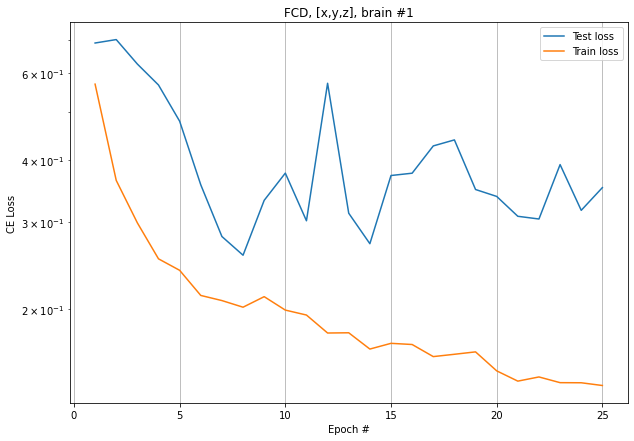

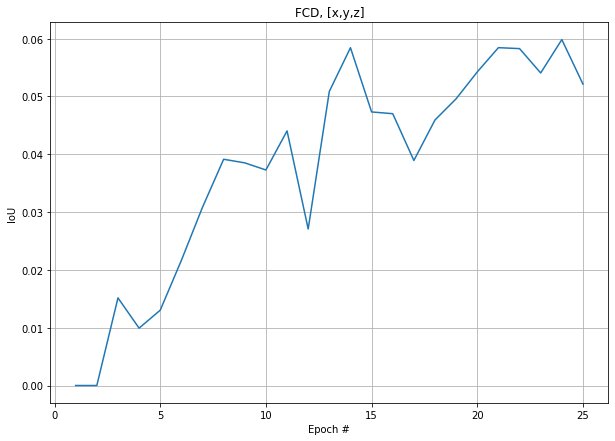

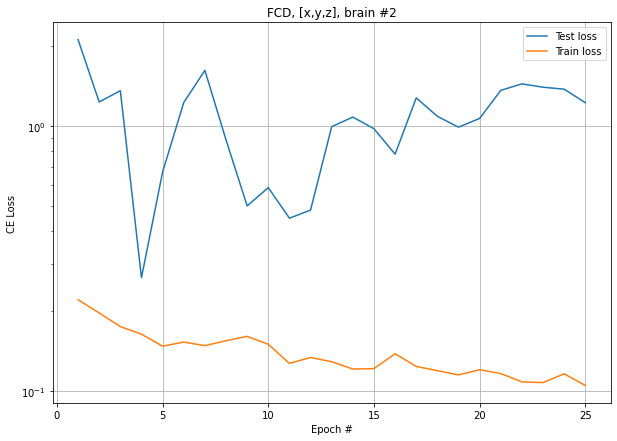

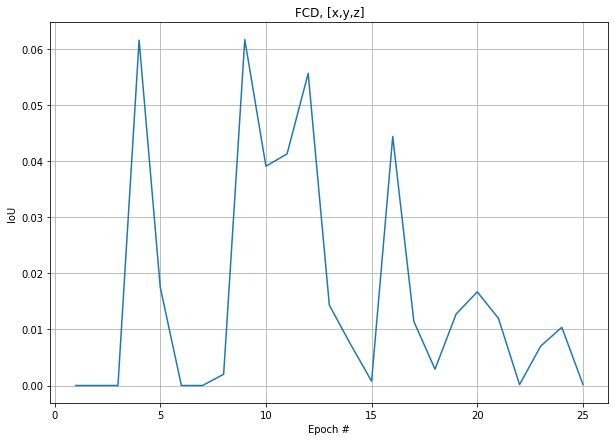

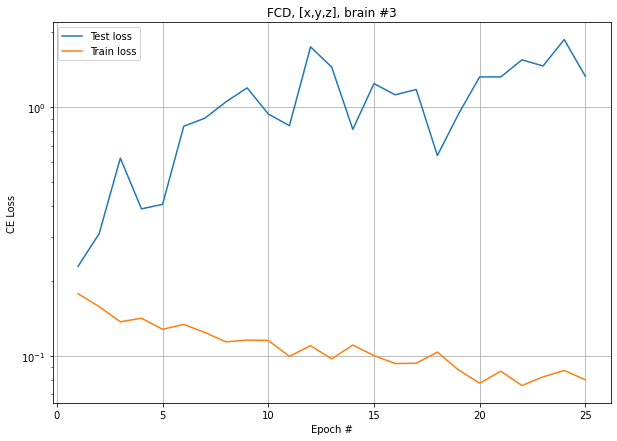

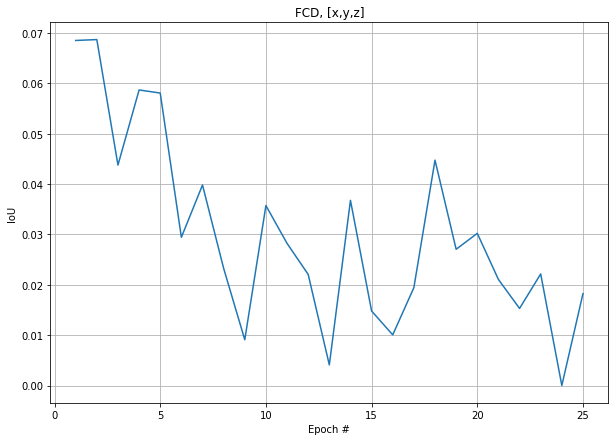

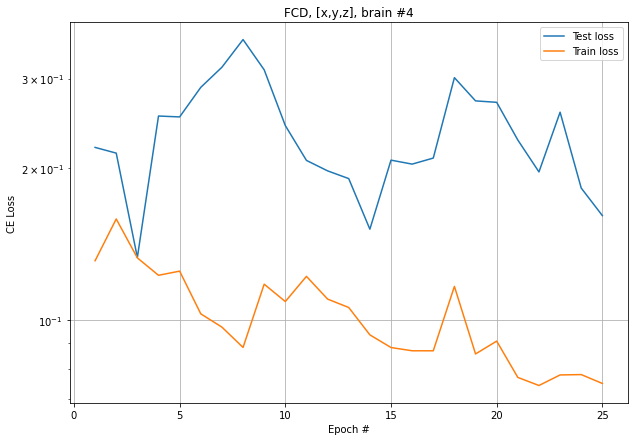

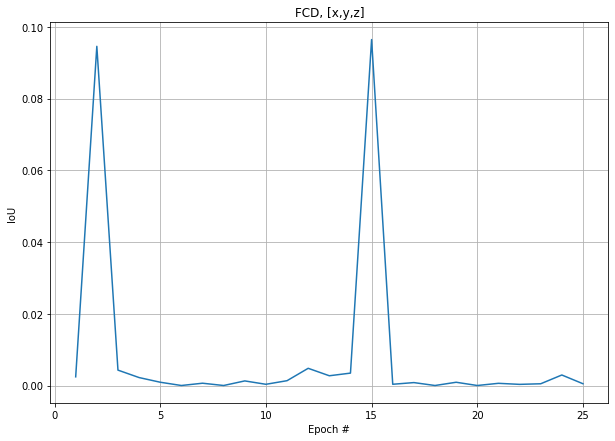

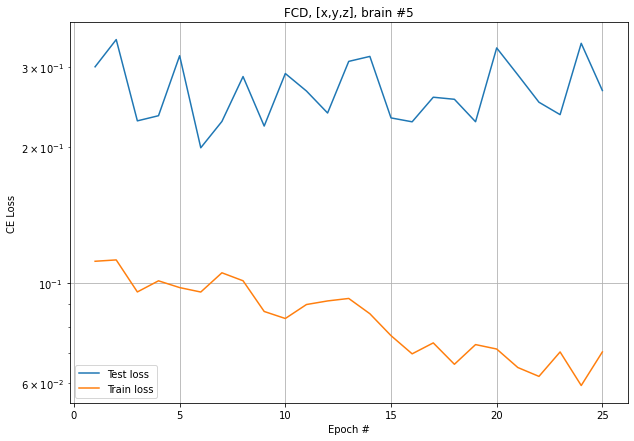

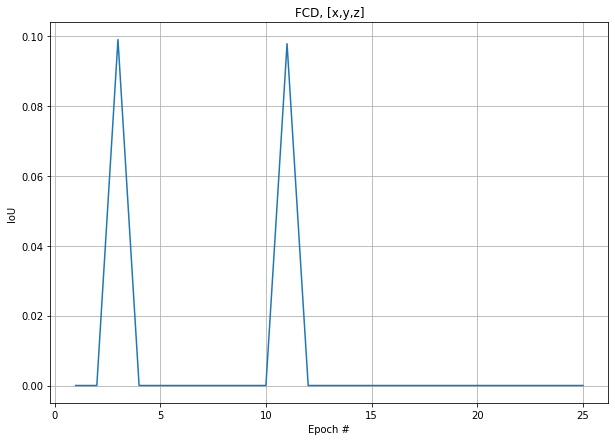

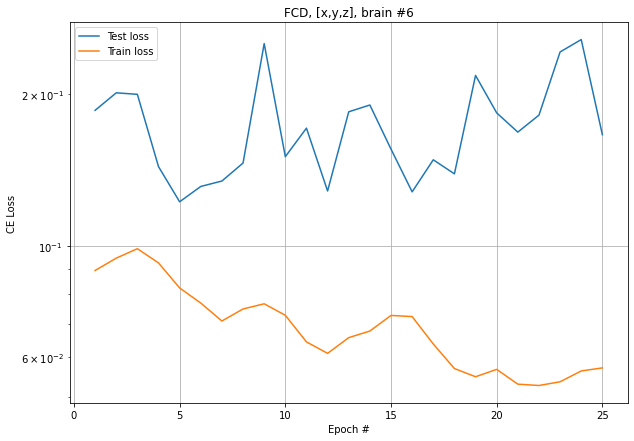

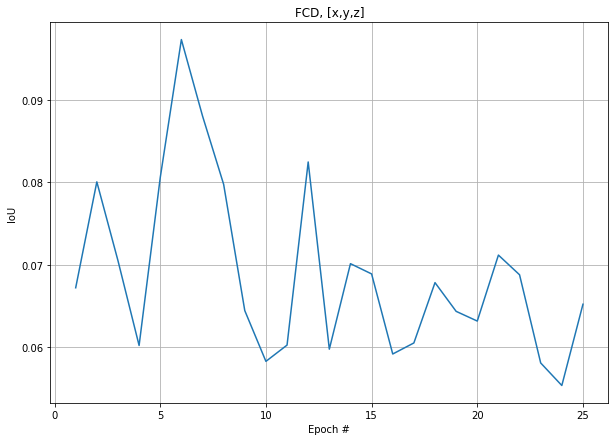

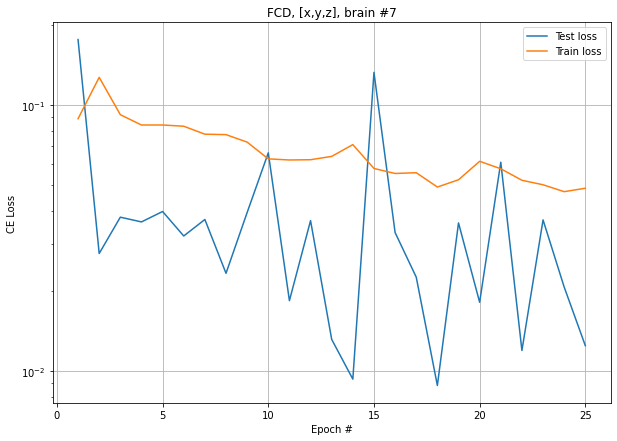

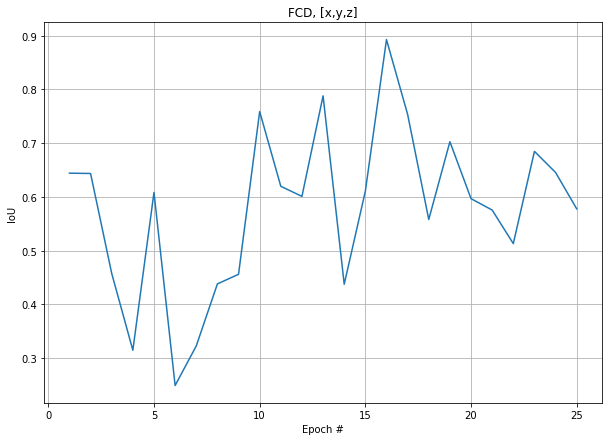

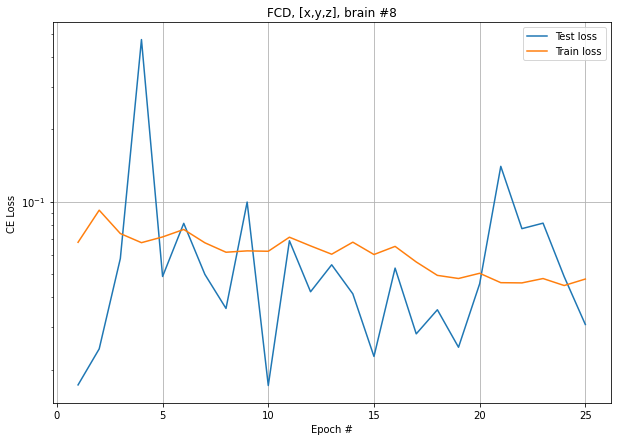

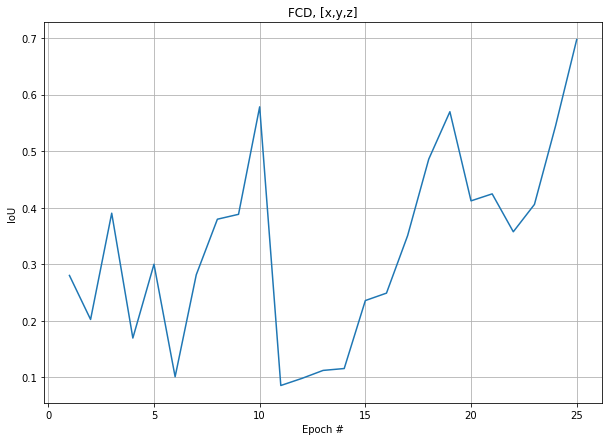

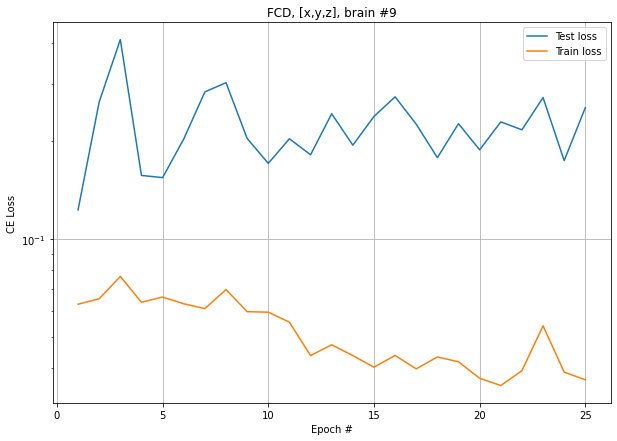

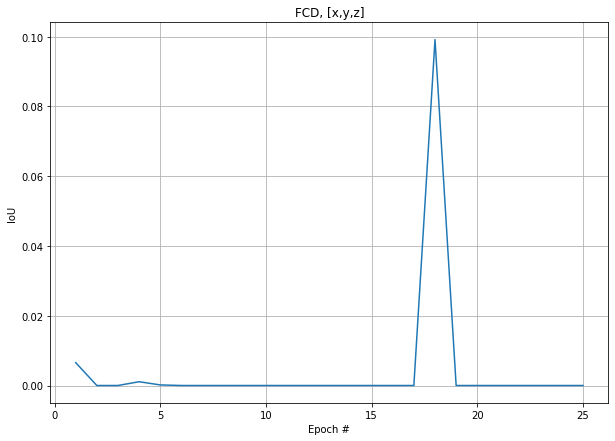

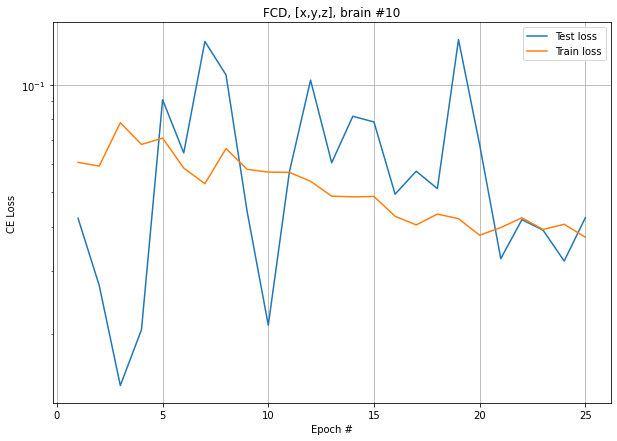

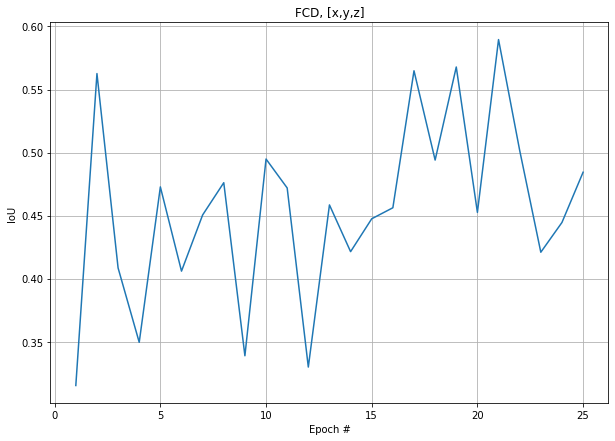

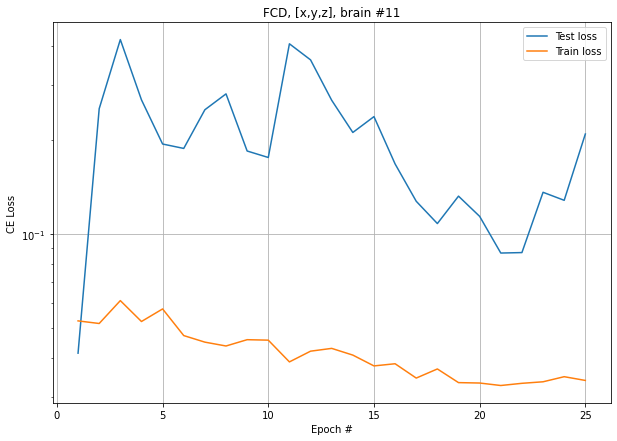

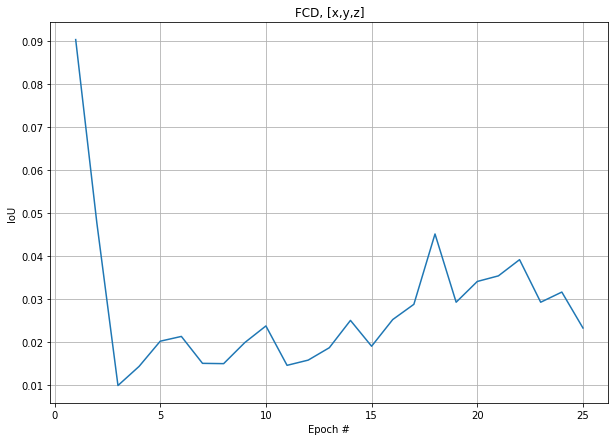

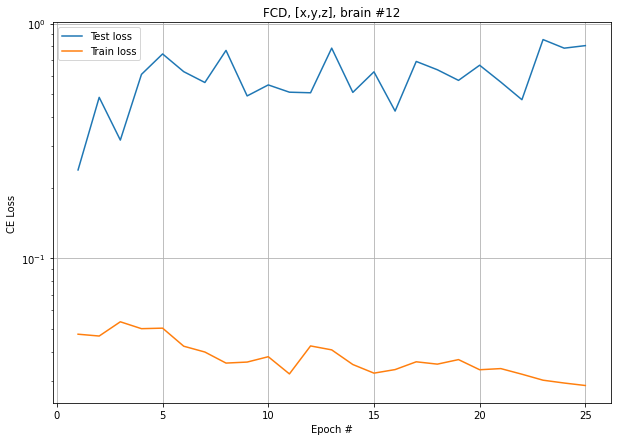

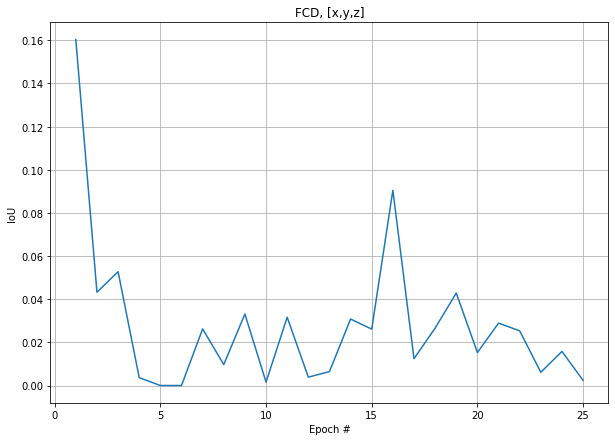

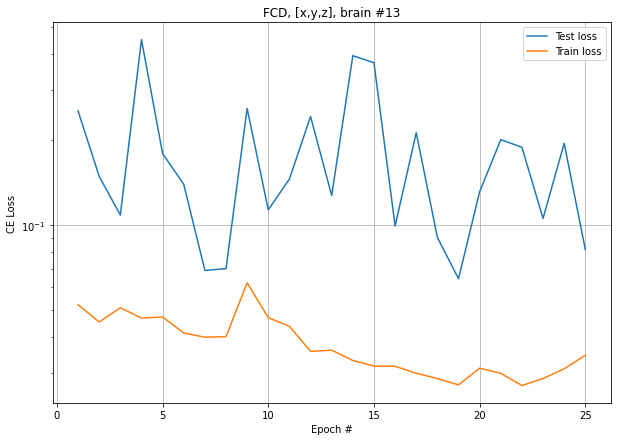

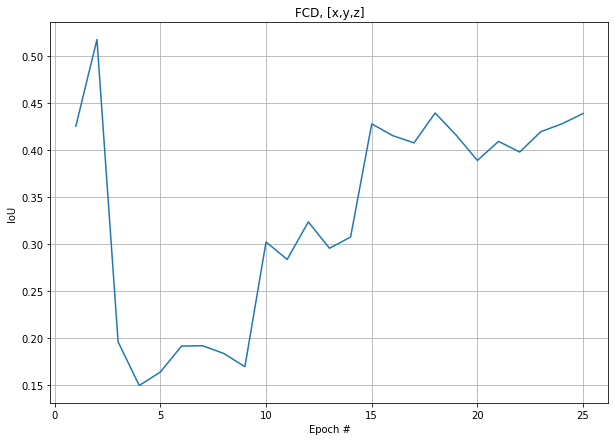

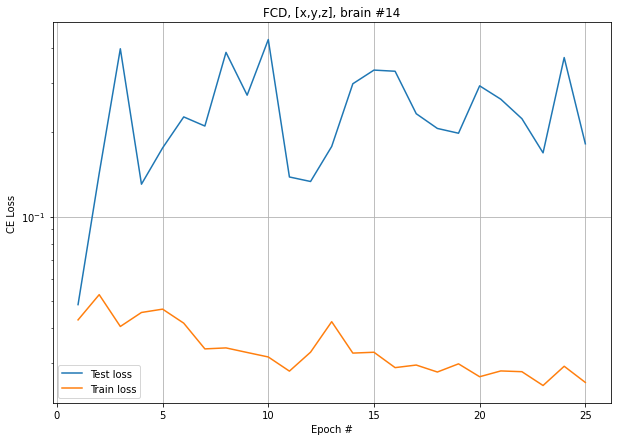

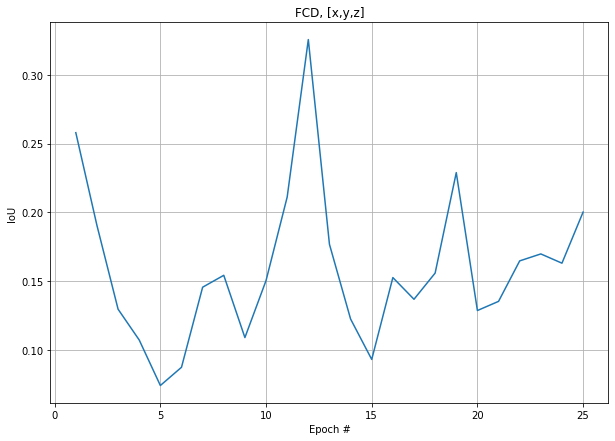

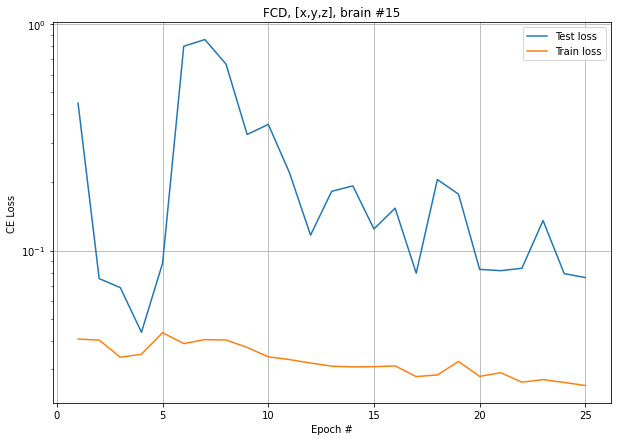

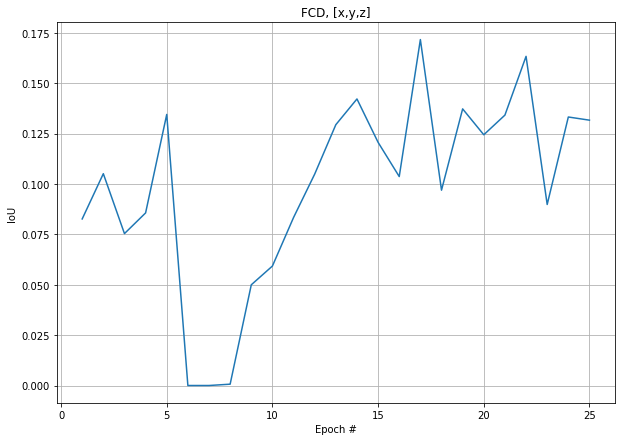

In [75]:
with open('3_exp_output.pkl', 'rb') as handle:
    res_dict = pickle.load(handle)
for i, e in enumerate(res_dict):    
    plt.figure(figsize = (10,7))
    plt.semilogy(range(1, len(res_dict[e]['iou'])+1),res_dict[e]['test_loss'], label = 'Test loss')
    plt.semilogy(range(1, len(res_dict[e]['iou'])+1),res_dict[e]['train_loss'], label = 'Train loss')
    plt.ylabel('CE Loss')
    plt.xlabel('Epoch #')
    plt.legend()
    plt.grid()
    plt.title('FCD, [x,y,z], brain #' + str(i+1))
    if i == 6:
        plt.savefig('fcd3.pdf')
    plt.show()

    plt.figure(figsize = (10,7))
    plt.plot(range(1, len(res_dict[e]['iou'])+1),res_dict[e]['iou'])
    plt.grid()
    plt.title('FCD, [x,y,z]')
    plt.ylabel('IoU')
    plt.xlabel('Epoch #')
    plt.show()